# HR(인적 자원 보통, 회사에서 인사과 이런 뜻을 의미한다.) Data 시각화,분석,예측

이 notebook에서는 광범위한 시각화와 분석,예측을 할 것이다.

진행하기전에 만약 시각화에 관심이 있다면 다른 notebook을 확인해라. 

**Stroke Prediction with SMOTE and LIME explainer**

https://www.kaggle.com/joshuaswords/predicting-a-stroke-95-acc-with-lime-explainer

**Exploratory Data Analysis - Student Performance**

https://www.kaggle.com/joshuaswords/data-visualisation-student-results

**Netflix Data Visualisation**

https://www.kaggle.com/joshuaswords/netflix-data-visualization

**Clustering and how you can visualise and share results in industry**

https://www.kaggle.com/joshuaswords/data-visualization-clustering-mall-data



# 본문

**문제 설명**: 어떤 사람이 새로운 직장을 찾을 확률을 예측한다. 

본질적으로 누가 구직자이고 아닌지 찾을 것이다.

**참고** - 이 notebook에서 초점을 둔 것은 시각화이므로 예측모델은 대부분 기본적인 조정을 통해 향상될수있다.

하지만 기업에서 매일 재훈련하는것은 어렵다. 좋은 모델은 실용적이고 더 낫다. 물론 이것은 케이스별로 평가되어야 한다.



In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import warnings
warnings.filterwarnings("ignore")        
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.gridspec as grid_spec
import seaborn as sns
import squarify
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


plt.rcParams["font.family"] = "serif"
plt.rcParams['figure.dpi'] = 200


/kaggle/input/malgun/malgun.ttf
/kaggle/input/hr-analytics-job-change-of-data-scientists/sample_submission.csv
/kaggle/input/hr-analytics-job-change-of-data-scientists/aug_test.csv
/kaggle/input/hr-analytics-job-change-of-data-scientists/aug_train.csv


In [2]:
path='../input/malgun/malgun.ttf'
import matplotlib.font_manager as fm
matplotlib.rcParams['axes.unicode_minus']=False
fontprop=fm.FontProperties(fname=path)

# Loading the data

In [3]:
aug_train = pd.read_csv('../input/hr-analytics-job-change-of-data-scientists/aug_train.csv')
aug_test = pd.read_csv('../input/hr-analytics-job-change-of-data-scientists/aug_test.csv')
aug_train.head(3)

enrollee_id      city  city_development_index gender  \
0         8949  city_103                   0.920   Male   
1        29725   city_40                   0.776   Male   
2        11561   city_21                   0.624    NaN   

       relevent_experience enrolled_university education_level  \
0  Has relevent experience       no_enrollment        Graduate   
1   No relevent experience       no_enrollment        Graduate   
2   No relevent experience    Full time course        Graduate   

  major_discipline experience company_size company_type last_new_job  \
0             STEM        >20          NaN          NaN            1   
1             STEM         15        50-99      Pvt Ltd           >4   
2             STEM          5          NaN          NaN        never   

   training_hours  target  
0              36     1.0  
1              47     0.0  
2              83     0.0

# 결측값 처리

전에도 말했다시피, 결측값 처리는 주관적이다.

보통 본인은 데이터가 얘기하는 무언가때문에 범주형 데이터들을 그대로 두기를 좋아한다.

게다가 난 성별없는것들도 둘것이다. target의 30%가 1이던데, 아직 이해못했지만 뭔가 얘기할게 있을 것이다.

기억할것은 Target:0은 구직자가 아니고, 1은 구직자라는 것이다.

In [4]:
# Check for nulls
aug_train.isna().sum()/len(aug_train)

enrollee_id               0.000000
city                      0.000000
city_development_index    0.000000
gender                    0.235306
relevent_experience       0.000000
enrolled_university       0.020148
education_level           0.024011
major_discipline          0.146832
experience                0.003393
company_size              0.309949
company_type              0.320493
last_new_job              0.022080
training_hours            0.000000
target                    0.000000
dtype: float64

In [5]:
# I like to keep categorical data where I can, as perhaps the fact that we do not have a company size or the company type
# could actually tell us something.


aug_train['last_new_job'] = aug_train['last_new_job'].apply(lambda x: 'Never' if x == 'never' else x) #just reads nicer
aug_train['enrolled_university'][aug_train['enrolled_university'] == 'no_enrollment'] = 'No Enrollment' #just reads nicer
aug_train['company_size'] = aug_train['company_size'].apply(lambda x: '10-49' if x == '10/49' else x) #diff replacement method

aug_train['experience'] = aug_train['experience'].apply(lambda x: '0' if x == '<1' else x)
aug_train['experience'] = aug_train['experience'].apply(lambda x: '20' if x == '>20' else x)


aug_train['company_size'].fillna('0',inplace=True)
aug_train['company_type'].fillna('Unknown',inplace=True)
aug_train['major_discipline'].fillna('Unknown',inplace=True)
aug_train['gender'].fillna('Not provided',inplace=True)


# Repeat steps on Test set

aug_test['last_new_job'] = aug_test['last_new_job'].apply(lambda x: 'Never' if x == 'never' else x) #just reads nicer
aug_test['enrolled_university'][aug_test['enrolled_university'] == 'no_enrollment'] = 'No Enrollment' #just reads nicer
aug_test['company_size'] = aug_test['company_size'].apply(lambda x: '10-49' if x == '10/49' else x) #diff replacement method

aug_test['experience'] = aug_test['experience'].apply(lambda x: '0' if x == '<1' else x)
aug_test['experience'] = aug_test['experience'].apply(lambda x: '20' if x == '>20' else x)

aug_test['company_size'].fillna('0',inplace=True)
aug_test['company_type'].fillna('Unknown',inplace=True)
aug_test['major_discipline'].fillna('Unknown',inplace=True)
aug_test['gender'].fillna('Not provided',inplace=True)



# This is what I mean with respect to the gender categories:

aug_train['target'].groupby(aug_train['gender']).mean()

gender
Female          0.263328
Male            0.227819
Not provided    0.308119
Other           0.261780
Name: target, dtype: float64

In [6]:
# I will drop the remaining missing data

aug_train.dropna(inplace=True)
aug_test.dropna(inplace=True)
aug_train.isna().sum()/len(aug_train)

enrollee_id               0.0
city                      0.0
city_development_index    0.0
gender                    0.0
relevent_experience       0.0
enrolled_university       0.0
education_level           0.0
major_discipline          0.0
experience                0.0
company_size              0.0
company_type              0.0
last_new_job              0.0
training_hours            0.0
target                    0.0
dtype: float64

In [7]:
# Converting objects to integers

aug_train['experience'] = aug_train['experience'].astype(str).astype(int)
aug_test['experience'] = aug_test['experience'].astype(str).astype(int)

aug_train['training_hours'] = aug_train['training_hours'].astype(str).astype(int)
aug_test['training_hours'] = aug_test['training_hours'].astype(str).astype(int)



범주형 변수들은 정렬하는것이 좋다. 이것은 나중에 말하고 싶은 스토리를 가능하게하고 더 잘 조작할 수 있다.

In [8]:
# Orders

ed_order = ['Primary School','High School','Graduate','Masters','Phd']
enroll_order = ['No Enrollment','Part time course','Full time course']
disc_order = ['STEM','Unknown','Humanities','Other','Business Degree','Arts','No Major']
exp_yrs_order = ['<1','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','>20']
exp_yrs_order_2 = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
size_order = ['0','<10', '10-49', '50-99', '100-500', '500-999', '1000-4999', '5000-9999', '10000+']
job_order = ['Never', '1', '2', '3', '4', '>4']
exp_order =['No relevant experience','Has relevant experience']
gender_order = ['Male','Female','Other','Not provided']
company_order = ['Pvt Ltd','Unknown','Funded Startup','Public Sector','Early Stage Startup','NGO','Other']
 
# for visuals
train_df = aug_train
test_df = aug_test



# Data Visualization 

**이것은 설명적인것이 아니라 탐색적인 시각화다.**

본인은 gridspec을 연습하기 위해서 사용할 것이다.

왜 사람들이 새로운 직장을 구하려고 하는지 이해해보려고 해보자

palette는 이것을 사용할 것이다.


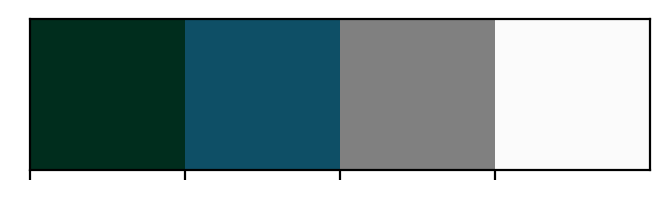

In [9]:

sns.palplot(['#002d1d','#0e4f66','gray','#fbfbfb'])


# 얼마나 많은 구직자가 있는지?

우선 난 얼마나 많은 구직자가 있는지 확인할 것이다.

balance 한 dataset인가? imbalance한가? 이 대답은 나중에 모델에 영향을 줄 수 있다.

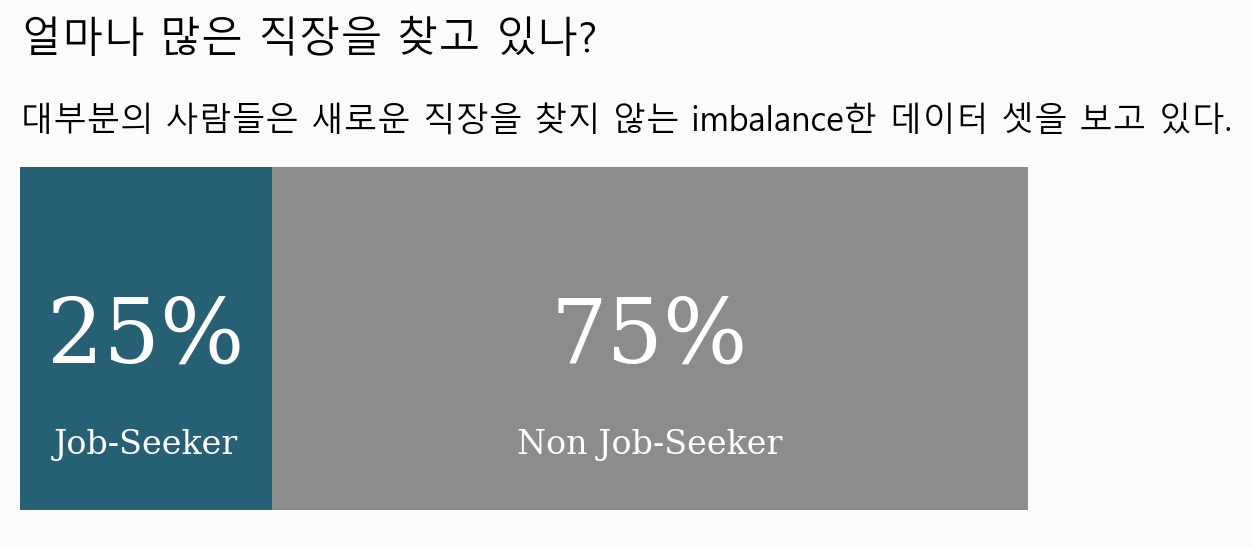

In [10]:
x=train_df.groupby(['target'])['target'].count()
y=len(train_df)
r=((x/y)).round(2)

ratio = pd.DataFrame(r).T

##
fig, ax = plt.subplots(1,1,figsize=(6.5, 2.5))
background_color = "#fbfbfb"
fig.patch.set_facecolor(background_color)
ax.set_facecolor(background_color) 

ax.barh(ratio.index, ratio[1.0], 
        color='#0e4f66', alpha=0.9, label='Job-Seeker')
ax.barh(ratio.index, ratio[0.0], left=ratio[1.0], 
        color='gray', alpha=0.9, label='Non Job-Seeker')

ax.set_xlim(0, 1)
ax.set_xticks([])
ax.set_yticks([])
#ax.set_yticklabels(mf_ratio.index, fontfamily='serif', fontsize=11)


# movie percentage
for i in ratio.index:
    ax.annotate(f"{int(ratio[1.0][i]*100)}%", 
                   xy=(ratio[1.0][i]/2, i),
                   va = 'center', ha='center',fontsize=32, fontweight='light', fontfamily='serif',
                   color='white')

    ax.annotate("Job-Seeker", 
                   xy=(ratio[1.0][i]/2, -0.25),
                   va = 'center', ha='center',fontsize=12, fontweight='light', fontfamily='serif',
                   color='white')
    
    
for i in ratio.index:
    ax.annotate(f"{int(ratio[0.0][i]*100)}%", 
                   xy=(ratio[1.0][i]+ratio[0.0][i]/2, i),
                   va = 'center', ha='center',fontsize=32, fontweight='light', fontfamily='serif',
                   color='white')
    ax.annotate("Non Job-Seeker", 
                   xy=(ratio[1.0][i]+ratio[0.0][i]/2, -0.25),
                   va = 'center', ha='center',fontsize=12, fontweight='light', fontfamily='serif',
                   color='white')



# Title & Subtitle
fig.text(0.125,1.075,'얼마나 많은 직장을 찾고 있나?', fontproperties=fontprop,fontsize=15, fontweight='bold')
fig.text(0.125,0.915,'대부분의 사람들은 새로운 직장을 찾지 않는 imbalance한 데이터 셋을 보고 있다.',fontproperties=fontprop,fontsize=12)  

for s in ['top', 'left', 'right', 'bottom']:
    ax.spines[s].set_visible(False)

#ax.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.06))

# Removing legend due to labelled plot
ax.legend().set_visible(False)
plt.show()

우리는 imbalanced 한 데이터셋을 가지고 있다. 이것은 구직자보다 비구직자가 많다는 뜻이다.

# 어떻게 훈련과 검증 세트를 비교할 수 있나?

여기서 gridspec을 보여줄것이다.

gridspec은 multiple plot들을 쉽게 그릴 수 있게 해준다. 


매우 가치가 있다고 생각한다. 왜냐하면 좁은 공간에 많은 정보를 넣을 수 있기 때문이다.


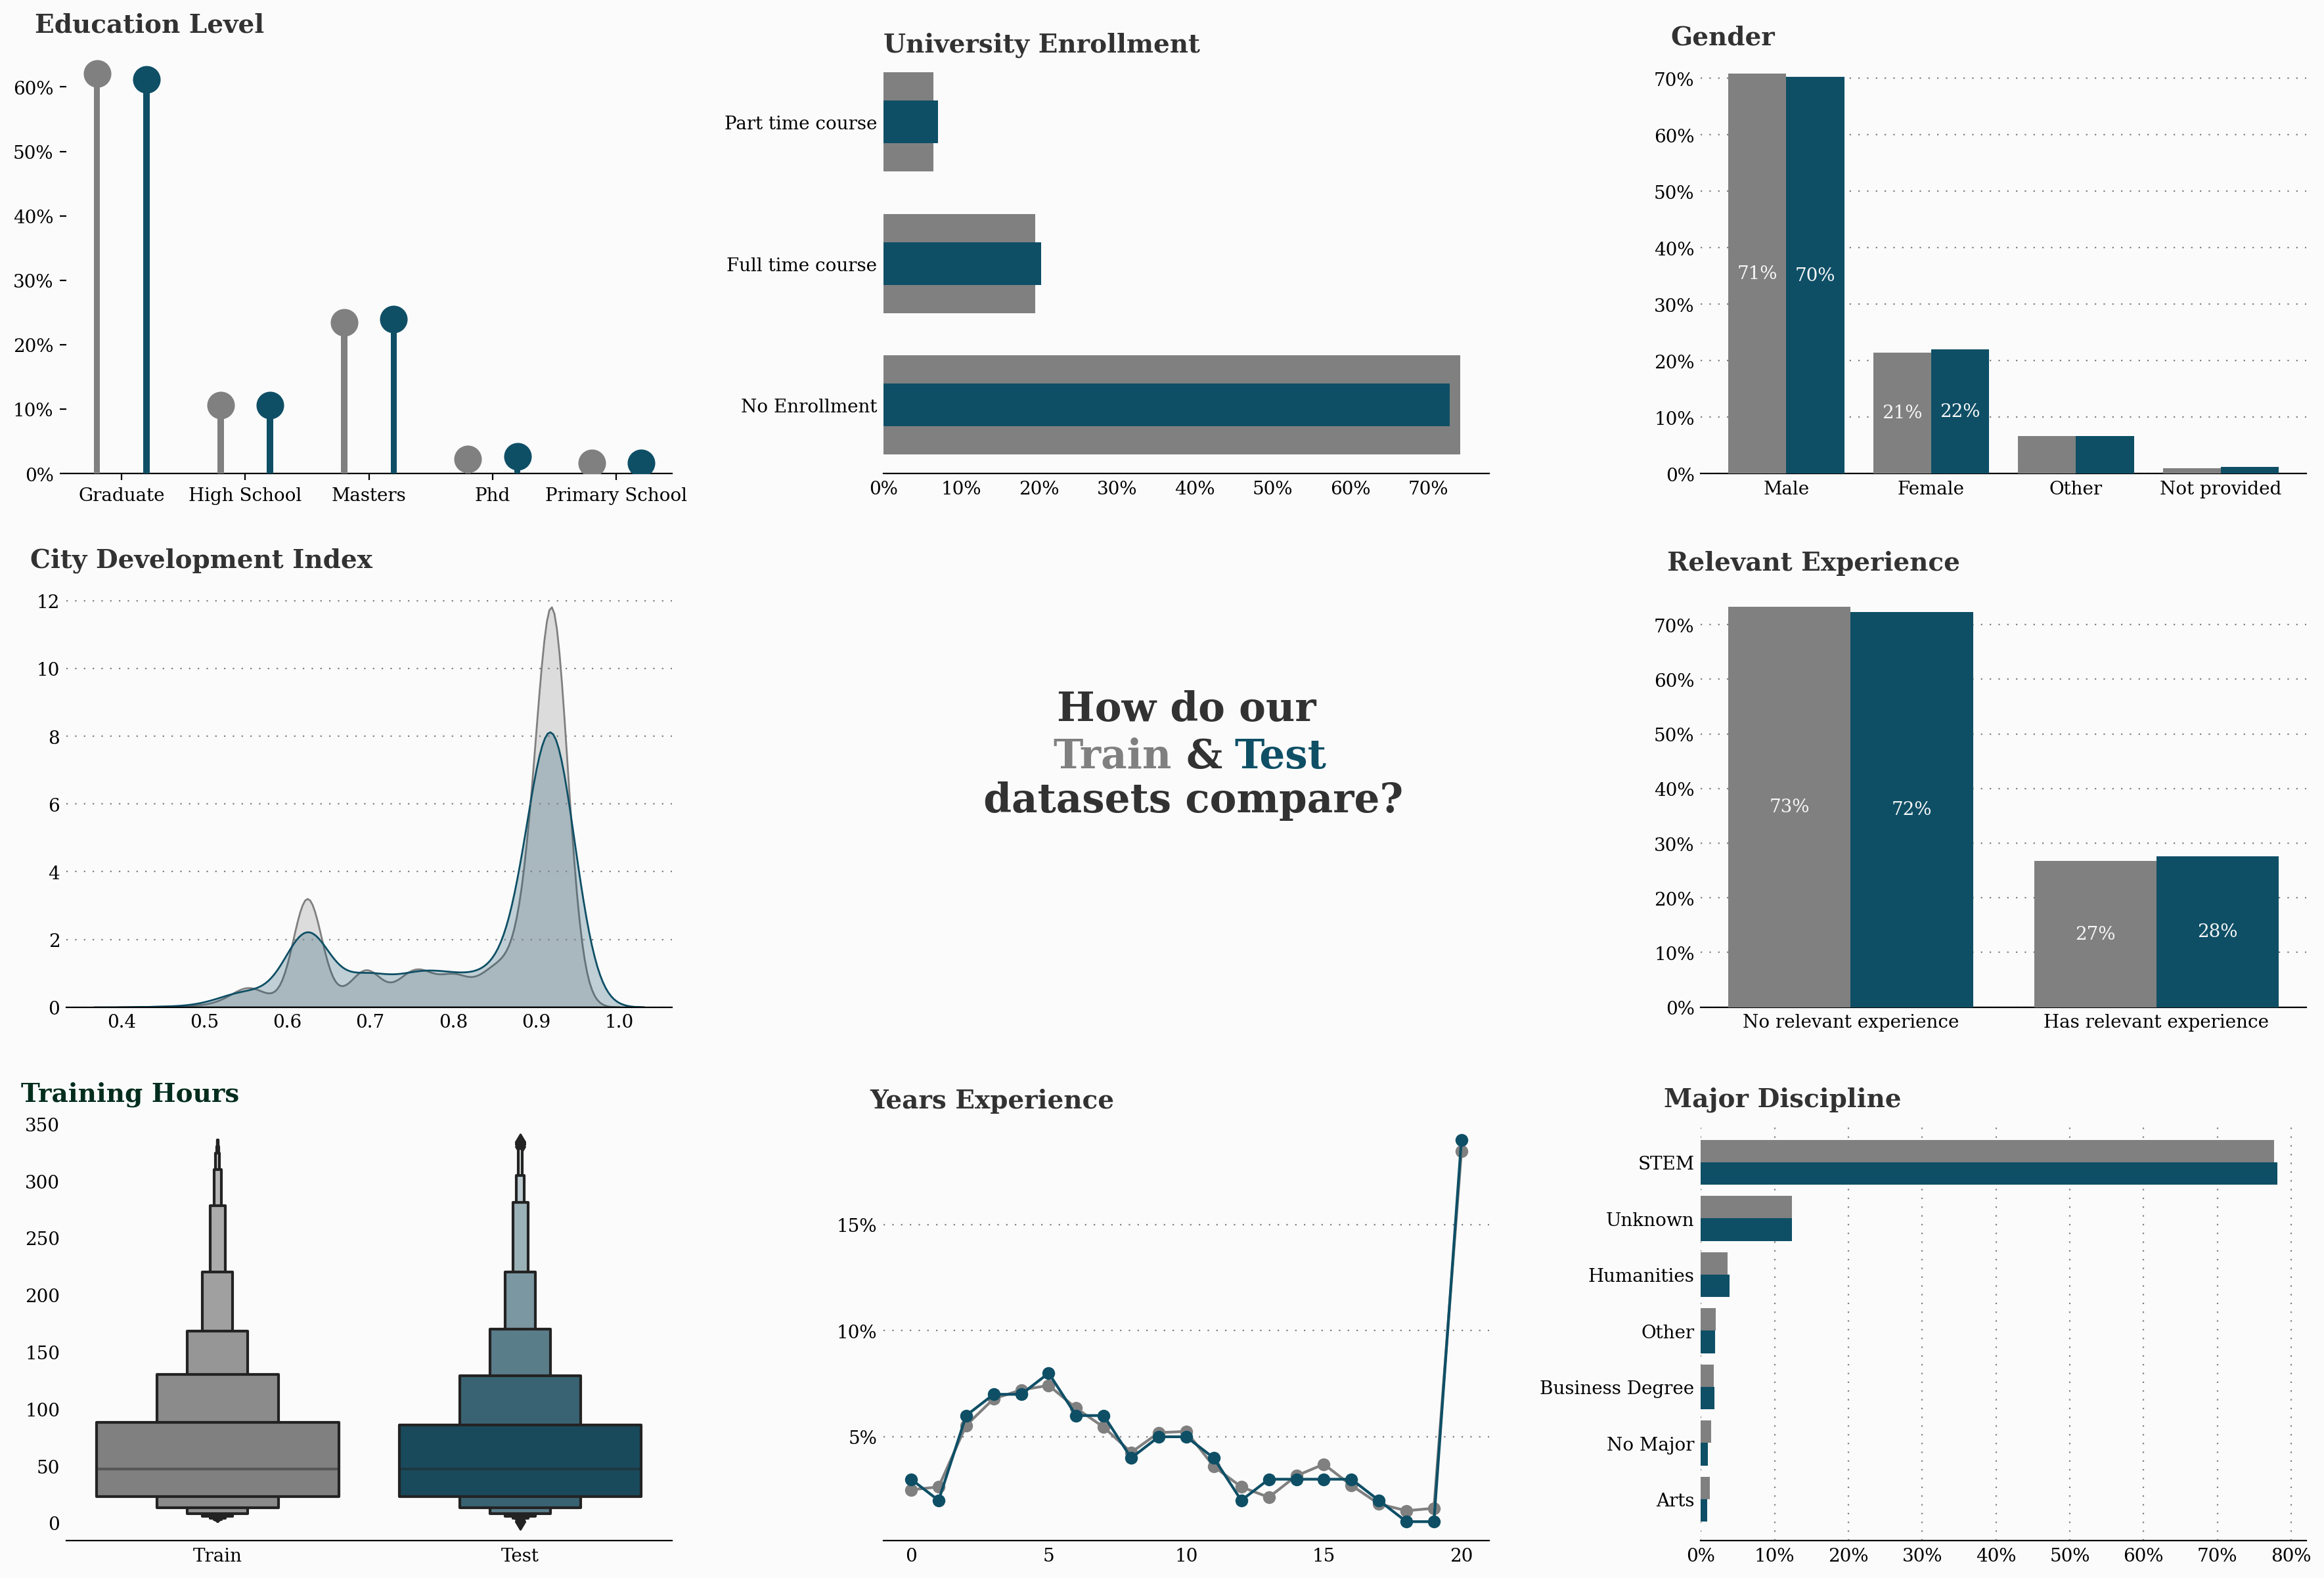

In [11]:
fig = plt.figure(figsize=(22,15))
gs = fig.add_gridspec(3, 3)
gs.update(wspace=0.35, hspace=0.27)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[1, 2])
ax6 = fig.add_subplot(gs[2, 0])
ax7 = fig.add_subplot(gs[2, 1])
ax8 = fig.add_subplot(gs[2, 2])

background_color = "#fbfbfb"
fig.patch.set_facecolor(background_color) # figure background color
ax0.set_facecolor(background_color) 
ax1.set_facecolor(background_color) 
ax2.set_facecolor(background_color)
ax3.set_facecolor(background_color) 
ax4.set_facecolor(background_color) 
ax5.set_facecolor(background_color) 
ax6.set_facecolor(background_color) 
ax7.set_facecolor(background_color) 
ax8.set_facecolor(background_color) 



# Ax0 - EDUCATION LEVEL
train_graph_temp_df = pd.DataFrame(train_df["education_level"].value_counts())
train_graph_temp_df["Percentage"] = train_graph_temp_df["education_level"].apply(lambda x: x/sum(train_graph_temp_df["education_level"])*100)
train_graph_temp_df = train_graph_temp_df.sort_index()

test_graph_temp_df = pd.DataFrame(test_df["education_level"].value_counts())
test_graph_temp_df["Percentage"] = test_graph_temp_df["education_level"].apply(lambda x: x/sum(test_graph_temp_df["education_level"])*100)
test_graph_temp_df = test_graph_temp_df.sort_index()

ax0.bar(np.arange(len(train_graph_temp_df.index)), height=train_graph_temp_df["Percentage"], zorder=3, color="gray", width=0.05)
ax0.scatter(np.arange(len(train_graph_temp_df.index)), train_graph_temp_df["Percentage"], zorder=3,s=200, color="gray")
ax0.bar(np.arange(len(test_graph_temp_df.index))+0.4, height=test_graph_temp_df["Percentage"], zorder=3, color="#0e4f66", width=0.05)
ax0.scatter(np.arange(len(test_graph_temp_df.index))+0.4, test_graph_temp_df["Percentage"], zorder=3,s=200, color="#0e4f66")
ax0.text(-0.5, 68.5, 'Education Level', 
         fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax0.yaxis.set_major_formatter(mtick.PercentFormatter())
ax0.yaxis.set_major_locator(mtick.MultipleLocator(10))
ax0.set_xticks(np.arange(len(train_graph_temp_df.index))+0.4 / 2)
ax0.set_xticklabels(list(train_graph_temp_df.index),rotation=0)


# Ax1 - ENROLLED IN UNIVESITY
train_graph_temp_df = pd.DataFrame(train_df["enrolled_university"].value_counts())
train_graph_temp_df["Percentage"] = train_graph_temp_df["enrolled_university"].apply(lambda x: x/sum(train_graph_temp_df["enrolled_university"])*100).loc[enroll_order]
test_graph_temp_df = pd.DataFrame(test_df["enrolled_university"].value_counts())
test_graph_temp_df["Percentage"] = test_graph_temp_df["enrolled_university"].apply(lambda x: x/sum(test_graph_temp_df["enrolled_university"])*100).loc[enroll_order]

ax1.text(0, 2.5, 'University Enrollment', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax1.barh(train_graph_temp_df.index, train_graph_temp_df['Percentage'], color="gray", zorder=3, height=0.7)
ax1.barh(test_graph_temp_df.index, test_graph_temp_df['Percentage'], color="#0e4f66", zorder=3, height=0.3)
ax1.xaxis.set_major_formatter(mtick.PercentFormatter())
ax1.xaxis.set_major_locator(mtick.MultipleLocator(10))

###
# Ax2 - GENDER 
train_graph_temp_df = pd.DataFrame(train_df["gender"].value_counts())
train_graph_temp_df["Percentage"] = train_graph_temp_df["gender"].apply(lambda x: x/sum(train_graph_temp_df["gender"])*100)
test_graph_temp_df = pd.DataFrame(test_df["gender"].value_counts())
test_graph_temp_df["Percentage"] = test_graph_temp_df["gender"].apply(lambda x: x/sum(test_graph_temp_df["gender"])*100)

x = np.arange(len(train_graph_temp_df))
ax2.text(-0.6, 76, 'Gender', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax2.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
ax2.bar(x, height=train_graph_temp_df["Percentage"], zorder=3, color="gray", width=0.4)
ax2.bar(x+0.4, height=test_graph_temp_df["Percentage"], zorder=3, color="#0e4f66", width=0.4)
ax2.set_xticks(x + 0.4 / 2)
ax2.set_xticklabels(['Male','Female','Other','Not provided'])
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
ax2.yaxis.set_major_locator(mtick.MultipleLocator(10))
for i,j in zip([0, 1], train_graph_temp_df["Percentage"]):
    ax2.annotate(f'{j:0.0f}%',xy=(i, j/2), color='#f6f6f6', horizontalalignment='center', verticalalignment='center')
for i,j in zip([0, 1], test_graph_temp_df["Percentage"]):
    ax2.annotate(f'{j:0.0f}%',xy=(i+0.4, j/2), color='#f6f6f6', horizontalalignment='center', verticalalignment='center')
    

    
## Ax 3 - CDI

ax3.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
train_graph_temp_df = pd.DataFrame(train_df["city_development_index"])
test_graph_temp_df = pd.DataFrame(test_df["city_development_index"])
sns.kdeplot(train_graph_temp_df["city_development_index"], ax=ax3,color="gray", shade=True, label="Train")
sns.kdeplot(test_graph_temp_df["city_development_index"], ax=ax3, color="#0e4f66", shade=True, label="Test")
ax3.text(0.29, 13, 'City Development Index', 
         fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax3.yaxis.set_major_locator(mtick.MultipleLocator(2))
ax3.set_ylabel('')    
ax3.set_xlabel('')

## AX4 - TITLE

ax4.spines["bottom"].set_visible(False)
ax4.tick_params(left=False, bottom=False)
ax4.set_xticklabels([])
ax4.set_yticklabels([])
ax4.text(0.5, 0.6, 'How do our\n\n datasets compare?', horizontalalignment='center', verticalalignment='center',
         fontsize=22, fontweight='bold', fontfamily='serif', color="#323232")

ax4.text(0.28,0.57,"Train", fontweight="bold", fontfamily='serif', fontsize=22, color='gray')
ax4.text(0.5,0.57,"&", fontweight="bold", fontfamily='serif', fontsize=22, color='#323232')
ax4.text(0.58,0.57,"Test", fontweight="bold", fontfamily='serif', fontsize=22, color='#0e4f66')




### Ax5 - RELEVANT EXPERIENCE
train_graph_temp_df = pd.DataFrame(train_df["relevent_experience"].value_counts())
train_graph_temp_df["Percentage"] = train_graph_temp_df["relevent_experience"].apply(lambda x: x/sum(train_graph_temp_df["relevent_experience"])*100)
test_graph_temp_df = pd.DataFrame(test_df["relevent_experience"].value_counts())
test_graph_temp_df["Percentage"] = test_graph_temp_df["relevent_experience"].apply(lambda x: x/sum(test_graph_temp_df["relevent_experience"])*100)

x = np.arange(len(train_graph_temp_df))
ax5.text(-0.4, 80, 'Relevant Experience', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax5.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
ax5.bar(x, height=train_graph_temp_df["Percentage"], zorder=3, color="gray", width=0.4)
ax5.bar(x+0.4, height=test_graph_temp_df["Percentage"], zorder=3, color="#0e4f66", width=0.4)
ax5.set_xticks(x + 0.4 / 2)
ax5.set_xticklabels(['No relevant experience','Has relevant experience'])
ax5.yaxis.set_major_formatter(mtick.PercentFormatter())
ax5.yaxis.set_major_locator(mtick.MultipleLocator(10))

for i,j in zip([0, 1, 2], train_graph_temp_df["Percentage"]):
    ax5.annotate(f'{j:0.0f}%',xy=(i, j/2), color='#f6f6f6', horizontalalignment='center', verticalalignment='center')
for i,j in zip([0, 1, 2], test_graph_temp_df["Percentage"]):
    ax5.annotate(f'{j:0.0f}%',xy=(i+0.4, j/2), color='#f6f6f6', horizontalalignment='center', verticalalignment='center')

    
    
# Ax6 - TRAINING HOURS
train_graph_temp_df = pd.DataFrame(train_df["training_hours"])
train_graph_temp_df["TrainTest"] = "Train"
test_graph_temp_df = pd.DataFrame(test_df["training_hours"])
test_graph_temp_df["TrainTest"] = "Test"
ax6.text(-0.65, 370, 'Training Hours', fontsize=14, fontweight='bold', fontfamily='serif', color="#002d1d")
comb_graph_temp_df = pd.concat([train_graph_temp_df, test_graph_temp_df], axis=0)
sns.boxenplot(ax=ax6, y="training_hours", x="TrainTest", data=comb_graph_temp_df, palette=["gray", "#0e4f66"])
ax6.set_xlabel("")
ax6.set_ylabel("")


# Ax7 - EXPERIENCE YRS
train_graph_temp_df = pd.DataFrame(train_df["experience"].value_counts())
train_graph_temp_df["Percentage"] = train_graph_temp_df["experience"].apply(lambda x: x/sum(train_graph_temp_df["experience"])*100)
train_graph_temp_df = train_graph_temp_df.sort_index()
test_graph_temp_df = pd.DataFrame(test_df["experience"].value_counts())
test_graph_temp_df["Percentage"] = round(test_graph_temp_df["experience"].apply(lambda x: x/sum(test_graph_temp_df["experience"])*100),).astype(int)
test_graph_temp_df = test_graph_temp_df.sort_index()
ax7.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
ax7.plot(train_graph_temp_df.index, train_graph_temp_df["Percentage"], zorder=3, color="gray", marker='o')
ax7.plot(test_graph_temp_df.index, test_graph_temp_df["Percentage"], zorder=3, color="#0e4f66", marker='o')
ax7.text(-1.5, 20.5, 'Years Experience', 
         fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")

ax7.set_yticklabels(labels = ['0   ', '5%','10%','15%'])
ax7.xaxis.set_major_locator(mtick.MultipleLocator(5))
ax7.yaxis.set_major_locator(mtick.MultipleLocator(5))


# Ax8 - MAJOR DISCIPLINE
train_graph_temp_df = pd.DataFrame(train_df["major_discipline"].value_counts())
train_graph_temp_df["Percentage"] = train_graph_temp_df["major_discipline"].apply(lambda x: x/sum(train_graph_temp_df["major_discipline"])*100)
#train_graph_temp_df = train_graph_temp_df.sort_index()
test_graph_temp_df = pd.DataFrame(test_df["major_discipline"].value_counts())
test_graph_temp_df["Percentage"] = test_graph_temp_df["major_discipline"].apply(lambda x: x/sum(test_graph_temp_df["major_discipline"])*100)

ax8.grid(color='gray', linestyle=':', axis='x', zorder=0,  dashes=(1,5))
ax8.barh(np.arange(len(train_graph_temp_df.index)), train_graph_temp_df["Percentage"], zorder=3, color="gray", height=0.4)
ax8.barh(np.arange(len(test_graph_temp_df.index))+0.4, test_graph_temp_df["Percentage"], zorder=3, color="#0e4f66", height=0.4)
ax8.text(-5, -0.8, 'Major Discipline', 
         fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax8.xaxis.set_major_formatter(mtick.PercentFormatter())
ax8.yaxis.set_major_locator(mtick.MultipleLocator(1))
ax8.set_yticks(np.arange(len(test_graph_temp_df.index))+0.4 / 2)
ax8.set_yticklabels(list(test_graph_temp_df.index))
ax8.invert_yaxis()

ax1.tick_params(axis=u'both', which=u'both',length=0)
ax2.tick_params(axis=u'both', which=u'both',length=0)
ax3.tick_params(axis=u'both', which=u'both',length=0)
ax4.tick_params(axis=u'both', which=u'both',length=0)
ax5.tick_params(axis=u'both', which=u'both',length=0)
ax6.tick_params(axis=u'both', which=u'both',length=0)
ax7.tick_params(axis=u'both', which=u'both',length=0)
ax8.tick_params(axis=u'both', which=u'both',length=0)



for s in ["top","right","left"]:
    ax0.spines[s].set_visible(False)
    ax1.spines[s].set_visible(False)
    ax2.spines[s].set_visible(False)
    ax3.spines[s].set_visible(False)
    ax4.spines[s].set_visible(False)
    ax5.spines[s].set_visible(False)
    ax6.spines[s].set_visible(False)
    ax7.spines[s].set_visible(False)
    ax8.spines[s].set_visible(False)

# 훈련 검증 세트가 비슷하다는 것은 좋은 뉴스다.

만약 훈련세트가 다르다면 우린 다른 어려운 시간에 있다. 

이제 훈련데이터가 실제로 예측을 하는데 도움이 되는지 확인해야한다. 

한번 탐색해본다.


너는 본인이 figure에 text를 통합한다는 것을 알고 있다. 난 종종 plot에 예를 들어, 데이터의 피크나 평균등의 주석을 달아 놓는다.

이 경우에, 본인은 우리가 보고있는것과 이것의 뜻을 설명하는것을 포함한다. 
이것은 여러분이 데이터를 이해할 수 있도록 돕는다. 하지만 본인이 말하고자하는 스토리에 일치가 될 수 있다. 

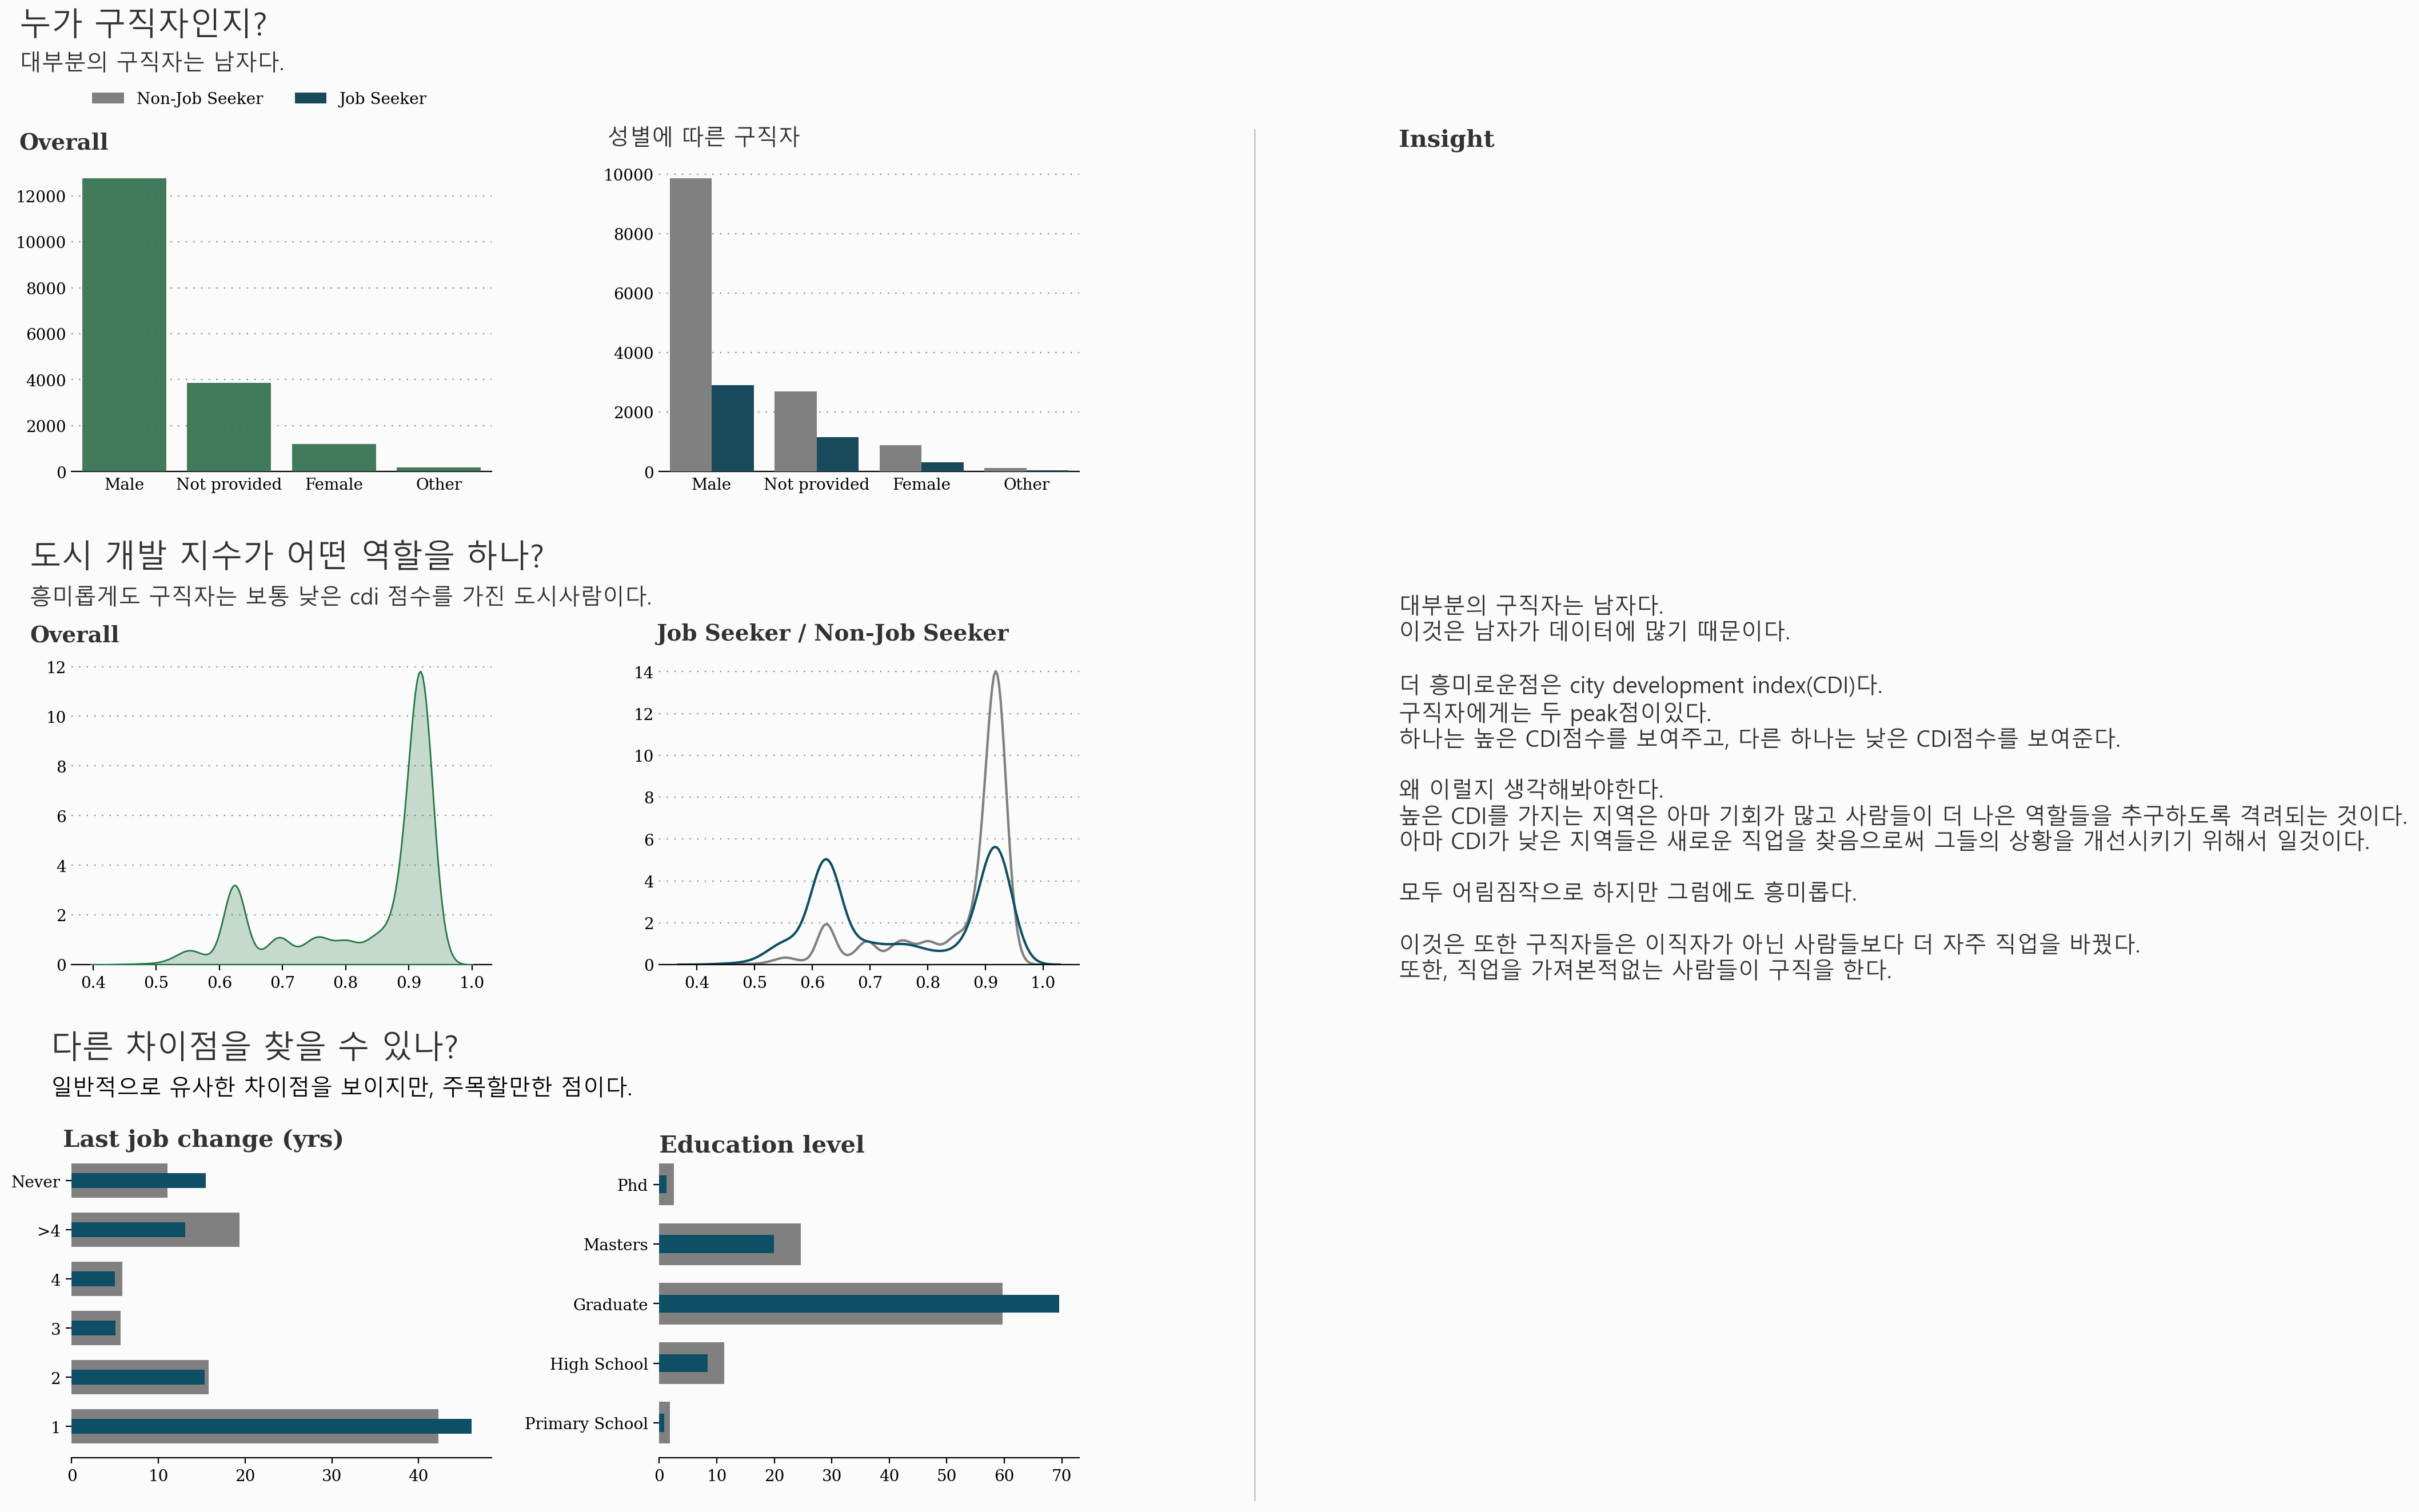

In [12]:
color_palette=["gray","#0e4f66"]

fig = plt.figure(figsize=(18,15))
gs = fig.add_gridspec(3, 3)
gs.update(wspace=0.4, hspace=0.6)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])
ax4 = fig.add_subplot(gs[2, 0])
ax5 = fig.add_subplot(gs[2, 1])

# Distribution
ax0.text(-1, 19000, '누가 구직자인지?', fontsize=20, fontweight='bold', fontproperties=fontprop, color="#323232")
ax0.text(-1, 17500, '대부분의 구직자는 남자다.', 
         fontsize=14, fontweight='light', fontproperties=fontprop, color="#323232")
ax0.text(-1, 14050, 'Overall', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax0.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(x=train_df["gender"], color="#247747", ax=ax0, zorder=3,alpha=0.9)
ax0.set_xlabel("")
ax0.set_ylabel("")


# Gender
ax1.text(-1, 11000, '성별에 따른 구직자', fontsize=14, fontweight='bold', fontproperties=fontprop, color="#323232")
ax1.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(x="gender", hue="target", data=train_df, palette=color_palette, ax=ax1, zorder=3)
legend_labels, _= ax1.get_legend_handles_labels()
ax1.legend(legend_labels, ["Non-Job Seeker", "Job Seeker"], ncol=2, bbox_to_anchor=(-0.52, 1.28), 
           facecolor=background_color, edgecolor=background_color)
ax1.set_xlabel("")
ax1.set_ylabel("")



fig.patch.set_facecolor(background_color) # figure background color
ax0.set_facecolor(background_color) # axes background color
ax1.set_facecolor(background_color) # axes background color
ax2.set_facecolor(background_color) # axes background color
ax3.set_facecolor(background_color) # axes background color
ax4.set_facecolor(background_color) # axes background color
ax5.set_facecolor(background_color) # axes background color

# CDI
ax2.text(0.3, 16, '도시 개발 지수가 어떤 역할을 하나?', fontsize=20, fontweight='bold', fontproperties=fontprop, color="#323232")
ax2.text(0.3, 14.5, '흥미롭게도 구직자는 보통 낮은 cdi 점수를 가진 도시사람이다.', 
         fontsize=14, fontweight='light', fontproperties=fontprop, color="#323232")
ax2.text(0.3, 13, 'Overall', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax2.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.kdeplot(train_df["city_development_index"], color="#247747", shade=True, ax=ax2, zorder=3)
ax2.set_xlabel("")
ax2.set_ylabel("")
#ax0.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=1))



ax3.text(0.33, 15.5, 'Job Seeker / Non-Job Seeker', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax3.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.kdeplot(train_df.loc[(train_df["target"]==0), "city_development_index"], color="gray", label="Not Survived", ax=ax3)
sns.kdeplot(train_df.loc[(train_df["target"]==1), "city_development_index"], color="#0e4f66", label="Survived", ax=ax3)
ax3.set_xlabel("")
ax3.set_ylabel("")
#ax1.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=1))


ax0.tick_params(axis=u'both', which=u'both',length=0)
ax1.tick_params(axis=u'both', which=u'both',length=0)
ax2.tick_params(axis=u'y', which=u'both',length=0)
ax3.tick_params(axis=u'y', which=u'both',length=0)

###
aug_train['count'] = 1
job_hunt_only = aug_train[aug_train['target']==1]
no_job_hunt_only = aug_train[aug_train['target']==0]

job_change = aug_train.groupby(['education_level','last_new_job'])['experience'].sum().unstack().loc[ed_order,job_order]

notseek_job_change = no_job_hunt_only.groupby(['target','last_new_job'])['count'].sum().unstack().T
seek_job_change = job_hunt_only.groupby(['target','last_new_job'])['count'].sum().unstack().T

notseek_job_change.columns = ['count']
seek_job_change.columns = ['count']

notseek_job_change["percentage"] = notseek_job_change["count"].apply(lambda x: x/sum(notseek_job_change["count"])) *100
seek_job_change["percentage"] = seek_job_change["count"].apply(lambda x: x/sum(seek_job_change["count"])) *100

ed_notseek_job_change = no_job_hunt_only.groupby(['target','education_level'])['count'].sum().unstack().T.loc[ed_order]
ed_seek_job_change = job_hunt_only.groupby(['target','education_level'])['count'].sum().unstack().T.loc[ed_order]

ed_notseek_job_change.columns = ['count']
ed_seek_job_change.columns = ['count']

ed_notseek_job_change["percentage"] = ed_notseek_job_change["count"].apply(lambda x: x/sum(ed_notseek_job_change["count"])) *100
ed_seek_job_change["percentage"] = ed_seek_job_change["count"].apply(lambda x: x/sum(ed_seek_job_change["count"])) *100

###


ax4.barh(notseek_job_change.index, notseek_job_change['percentage'], color="gray", zorder=3, height=0.7)
ax4.barh(seek_job_change.index, seek_job_change['percentage'], color="#0e4f66", zorder=3, height=0.3)

ax4.xaxis.set_major_locator(mtick.MultipleLocator(10))


##
ax5.barh(ed_notseek_job_change.index, ed_notseek_job_change['percentage'], color="gray", zorder=3, height=0.7)
ax5.barh(ed_seek_job_change.index, ed_seek_job_change['percentage'], color="#0e4f66", zorder=3, height=0.3)

ax5.xaxis.set_major_locator(mtick.MultipleLocator(10))

##
ax4.text(-1, 5.7, 'Last job change (yrs)',fontsize=15, fontweight='bold', fontfamily='serif',color='#323232')
ax5.text(0, 4.55, 'Education level', fontsize=15, fontweight='bold', fontfamily='serif',color='#323232')

ax4.text(-2.5, 7.5, '다른 차이점을 찾을 수 있나?', 
         fontsize=20, fontweight='bold', fontproperties=fontprop,color='#323232')

ax4.text(-2.5, 6.75, 
         '일반적으로 유사한 차이점을 보이지만, 주목할만한 점이다.', 
         fontsize=14, fontweight='light', fontproperties=fontprop)


####

fig.text(0.77, 0.89
         , 'Insight', fontsize=15, fontweight='bold', fontfamily='serif',color='#323232')

fig.text(0.77, 0.39, '''
대부분의 구직자는 남자다. 
이것은 남자가 데이터에 많기 때문이다.

더 흥미로운점은 city development index(CDI)다. 
구직자에게는 두 peak점이있다. 
하나는 높은 CDI점수를 보여주고, 다른 하나는 낮은 CDI점수를 보여준다.

왜 이럴지 생각해봐야한다. 
높은 CDI를 가지는 지역은 아마 기회가 많고 사람들이 더 나은 역할들을 추구하도록 격려되는 것이다.
아마 CDI가 낮은 지역들은 새로운 직업을 찾음으로써 그들의 상황을 개선시키기 위해서 일것이다.

모두 어림짐작으로 하지만 그럼에도 흥미롭다.

이것은 또한 구직자들은 이직자가 아닌 사람들보다 더 자주 직업을 바꿨다. 
또한, 직업을 가져본적없는 사람들이 구직을 한다. 
'''
         , fontsize=14, fontweight='light', fontproperties=fontprop,color='#323232')


import matplotlib.lines as lines
l1 = lines.Line2D([0.7, 0.7], [0.1, 0.9], transform=fig.transFigure, figure=fig,color='black',lw=0.2)
fig.lines.extend([l1])

for s in ["top","right","left"]:
    ax0.spines[s].set_visible(False)
    ax1.spines[s].set_visible(False)
    ax2.spines[s].set_visible(False)
    ax3.spines[s].set_visible(False) 
    ax4.spines[s].set_visible(False)
    ax5.spines[s].set_visible(False)

# 이제 company size나 employee experience 등 다른 요인들을 보자.

많은 경험을 가진 직원들이 이직을 할까?

큰 회사의 직원들이 덜 가치 있다고 할까?

작은 회사의 직원들이 새로운 기회를 찾나?

둘 다 그럴것 같다. 이것들은 eda를 시작할 좋은 질문들이다.


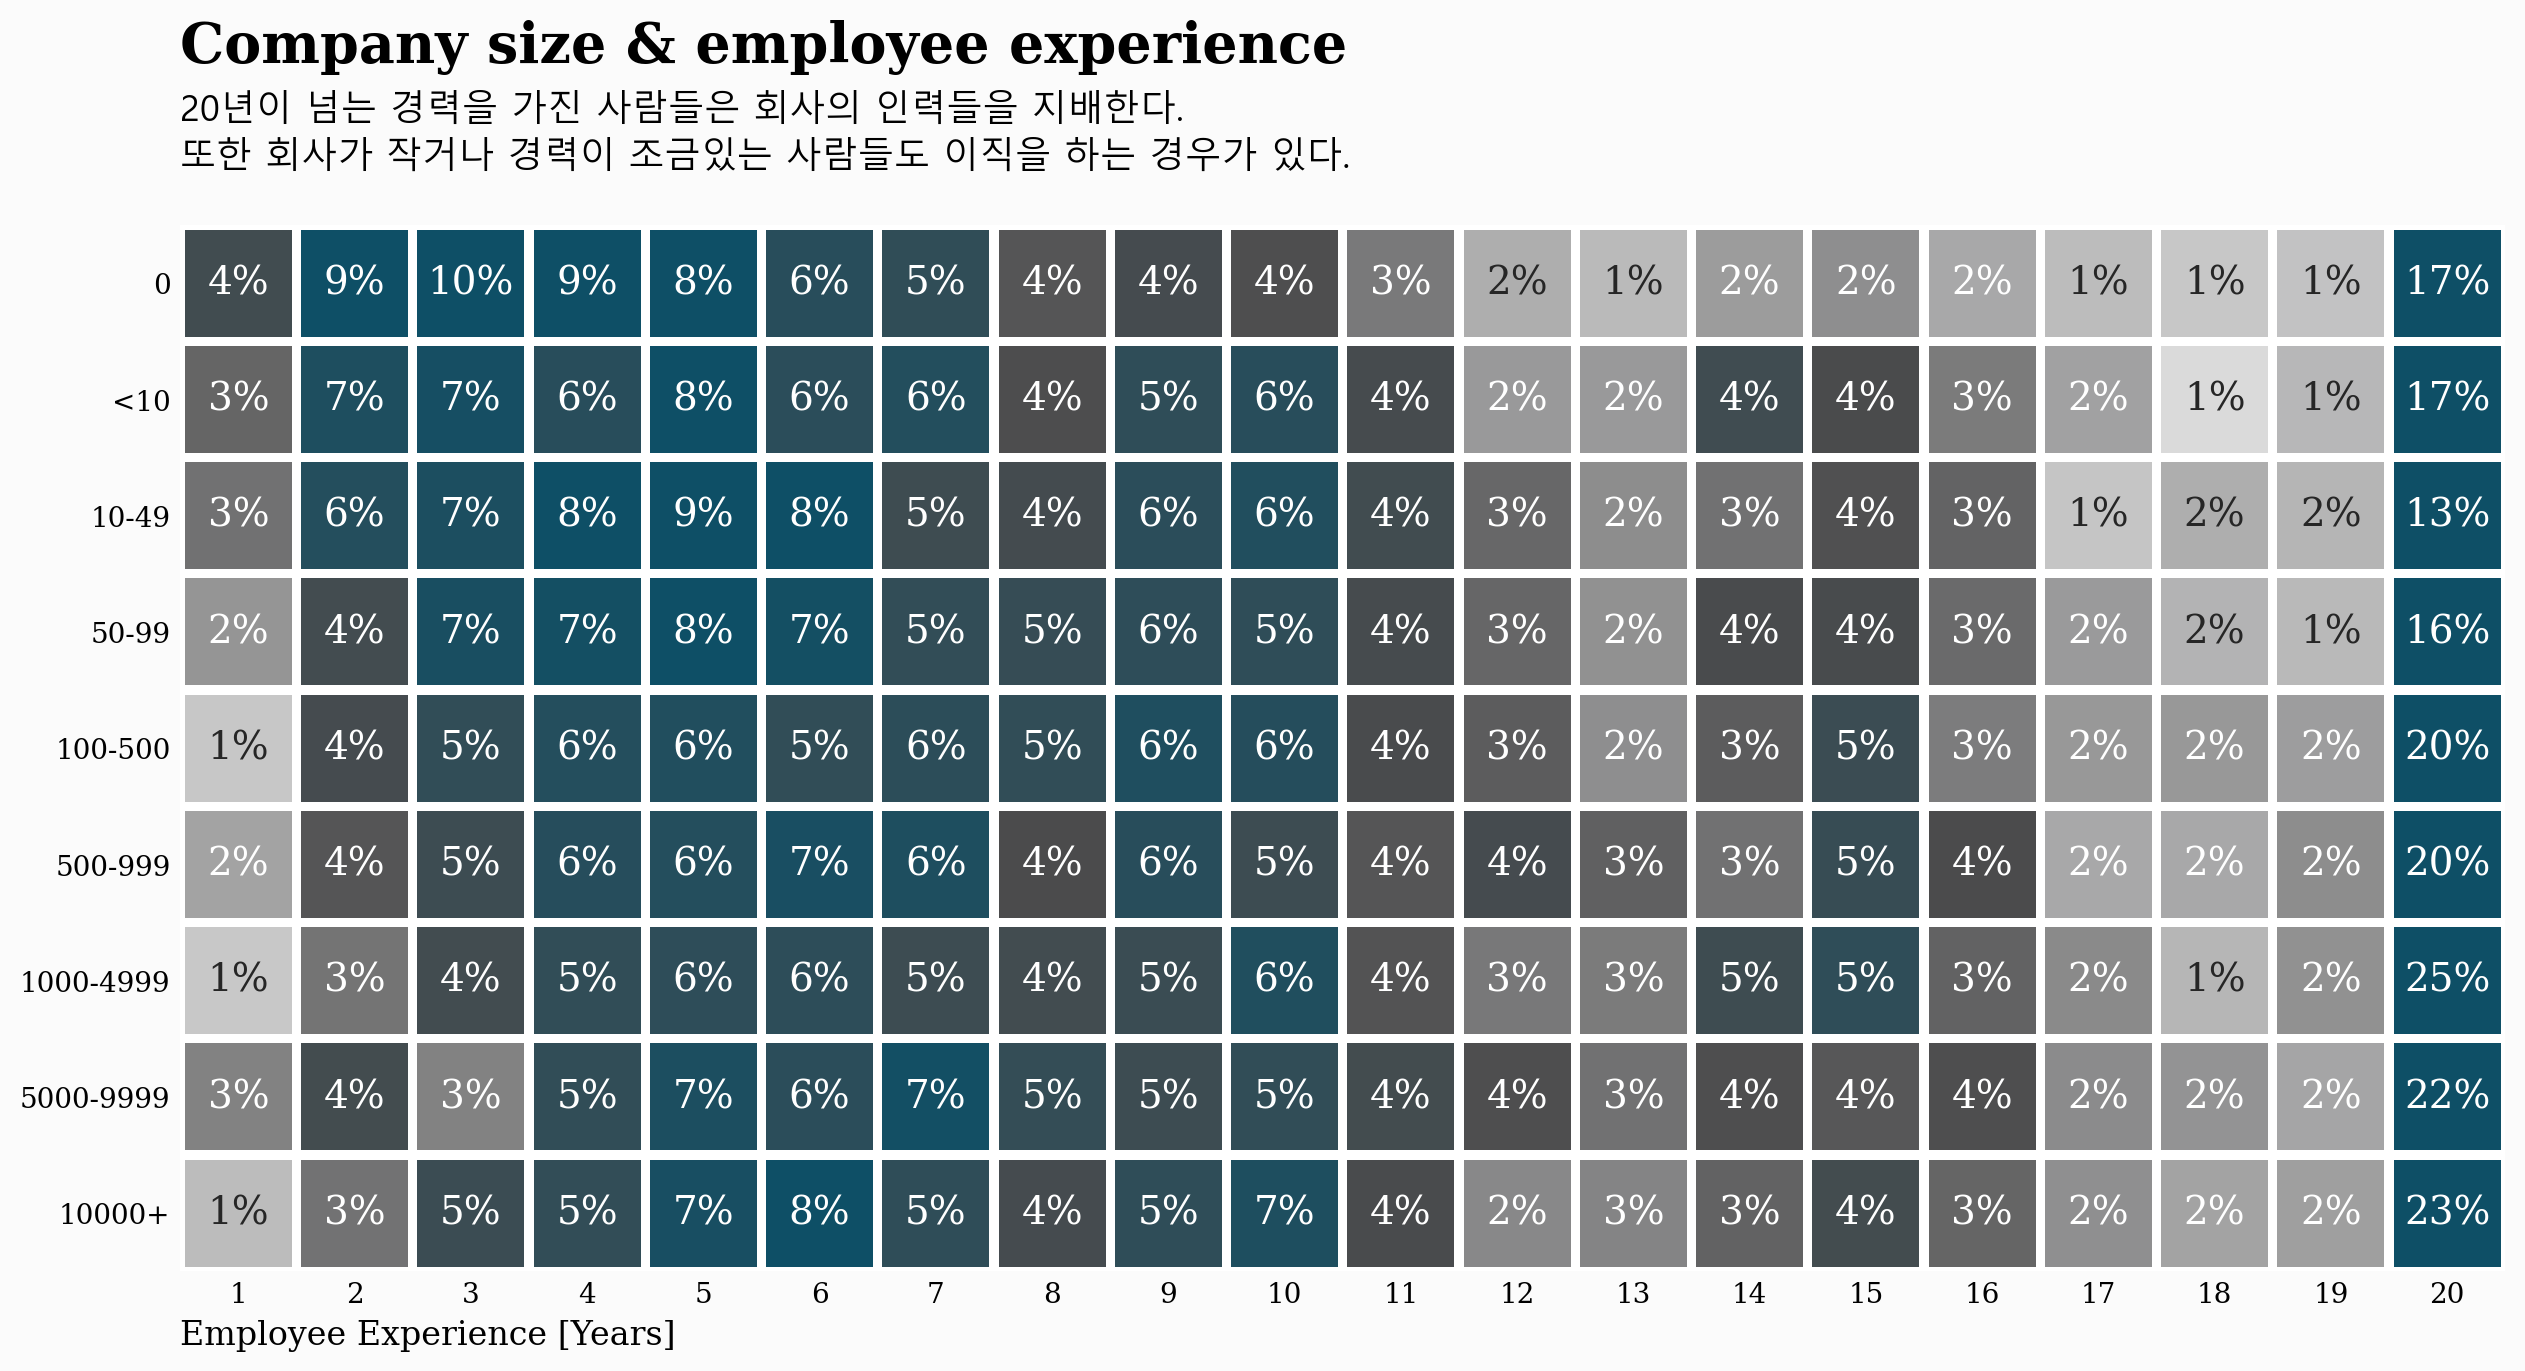

In [13]:
aug_train['count'] = 1
pv_gen_size = pd.pivot_table(aug_train, values='count',index=['gender'],columns=['company_size'],aggfunc=np.sum).loc[gender_order, size_order]

ct_gen_size = pd.crosstab(aug_train['company_size'],aug_train['experience'], normalize='index').loc[size_order,exp_yrs_order_2]



# Setting up figure and axes
fig = plt.figure(figsize=(15,10)) # create figure
gs = fig.add_gridspec(2, 1)
gs.update(wspace=0, hspace=-0.09)
ax0 = fig.add_subplot(gs[:,:])
#ax1 = fig.add_subplot(gs[1, 0])

colors = ["#fbfbfb", "#4b4b4c","#0e4f66"]
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

sns.heatmap(ax=ax0, data=ct_gen_size, linewidths=.1, vmin=0, vmax=0.075,
            square=True, cbar_kws={"orientation": "horizontal"}, cbar=False, cmap=colormap,linewidth=3, annot=True, fmt='1.0%',annot_kws={"fontsize":14})

# Change background color
background_color = "#fbfbfb"
fig.patch.set_facecolor(background_color) # figure background color
ax0.set_facecolor(background_color) # axes background color

ax0.set_xlabel("Employee Experience [Years]",fontfamily='serif',fontsize=12,loc='left')
ax0.set_ylabel("")

for s in ["top","right","left"]:
    ax0.spines[s].set_visible(False)

    
ax0.text(0, -1.4, 
         'Company size & employee experience', 
         fontsize=20, 
         fontweight='bold', 
         fontfamily='serif',
        )

ax0.text(0, -0.9, 
         '20년이 넘는 경력을 가진 사람들은 회사의 인력들을 지배한다.', 
         fontsize=13, 
         fontweight='light', 
         fontproperties=fontprop,
        )
ax0.text(0, -0.5, 
         '또한 회사가 작거나 경력이 조금있는 사람들도 이직을 하는 경우가 있다.', 
         fontsize=13, 
         fontweight='light', 
         fontproperties=fontprop,
        )

ax0.tick_params(axis=u'both', which=u'both',length=0)


직원들의 경력이 오를수록 그들은 큰 회사로 가고 싶어한다.

왜이렇게 되냐면, 회사가 클수록 pay도 많고, 직업 안정성도 있기 때문이다.

# Employee Experience & Company Size

주목할만한 차이점이 있었나?

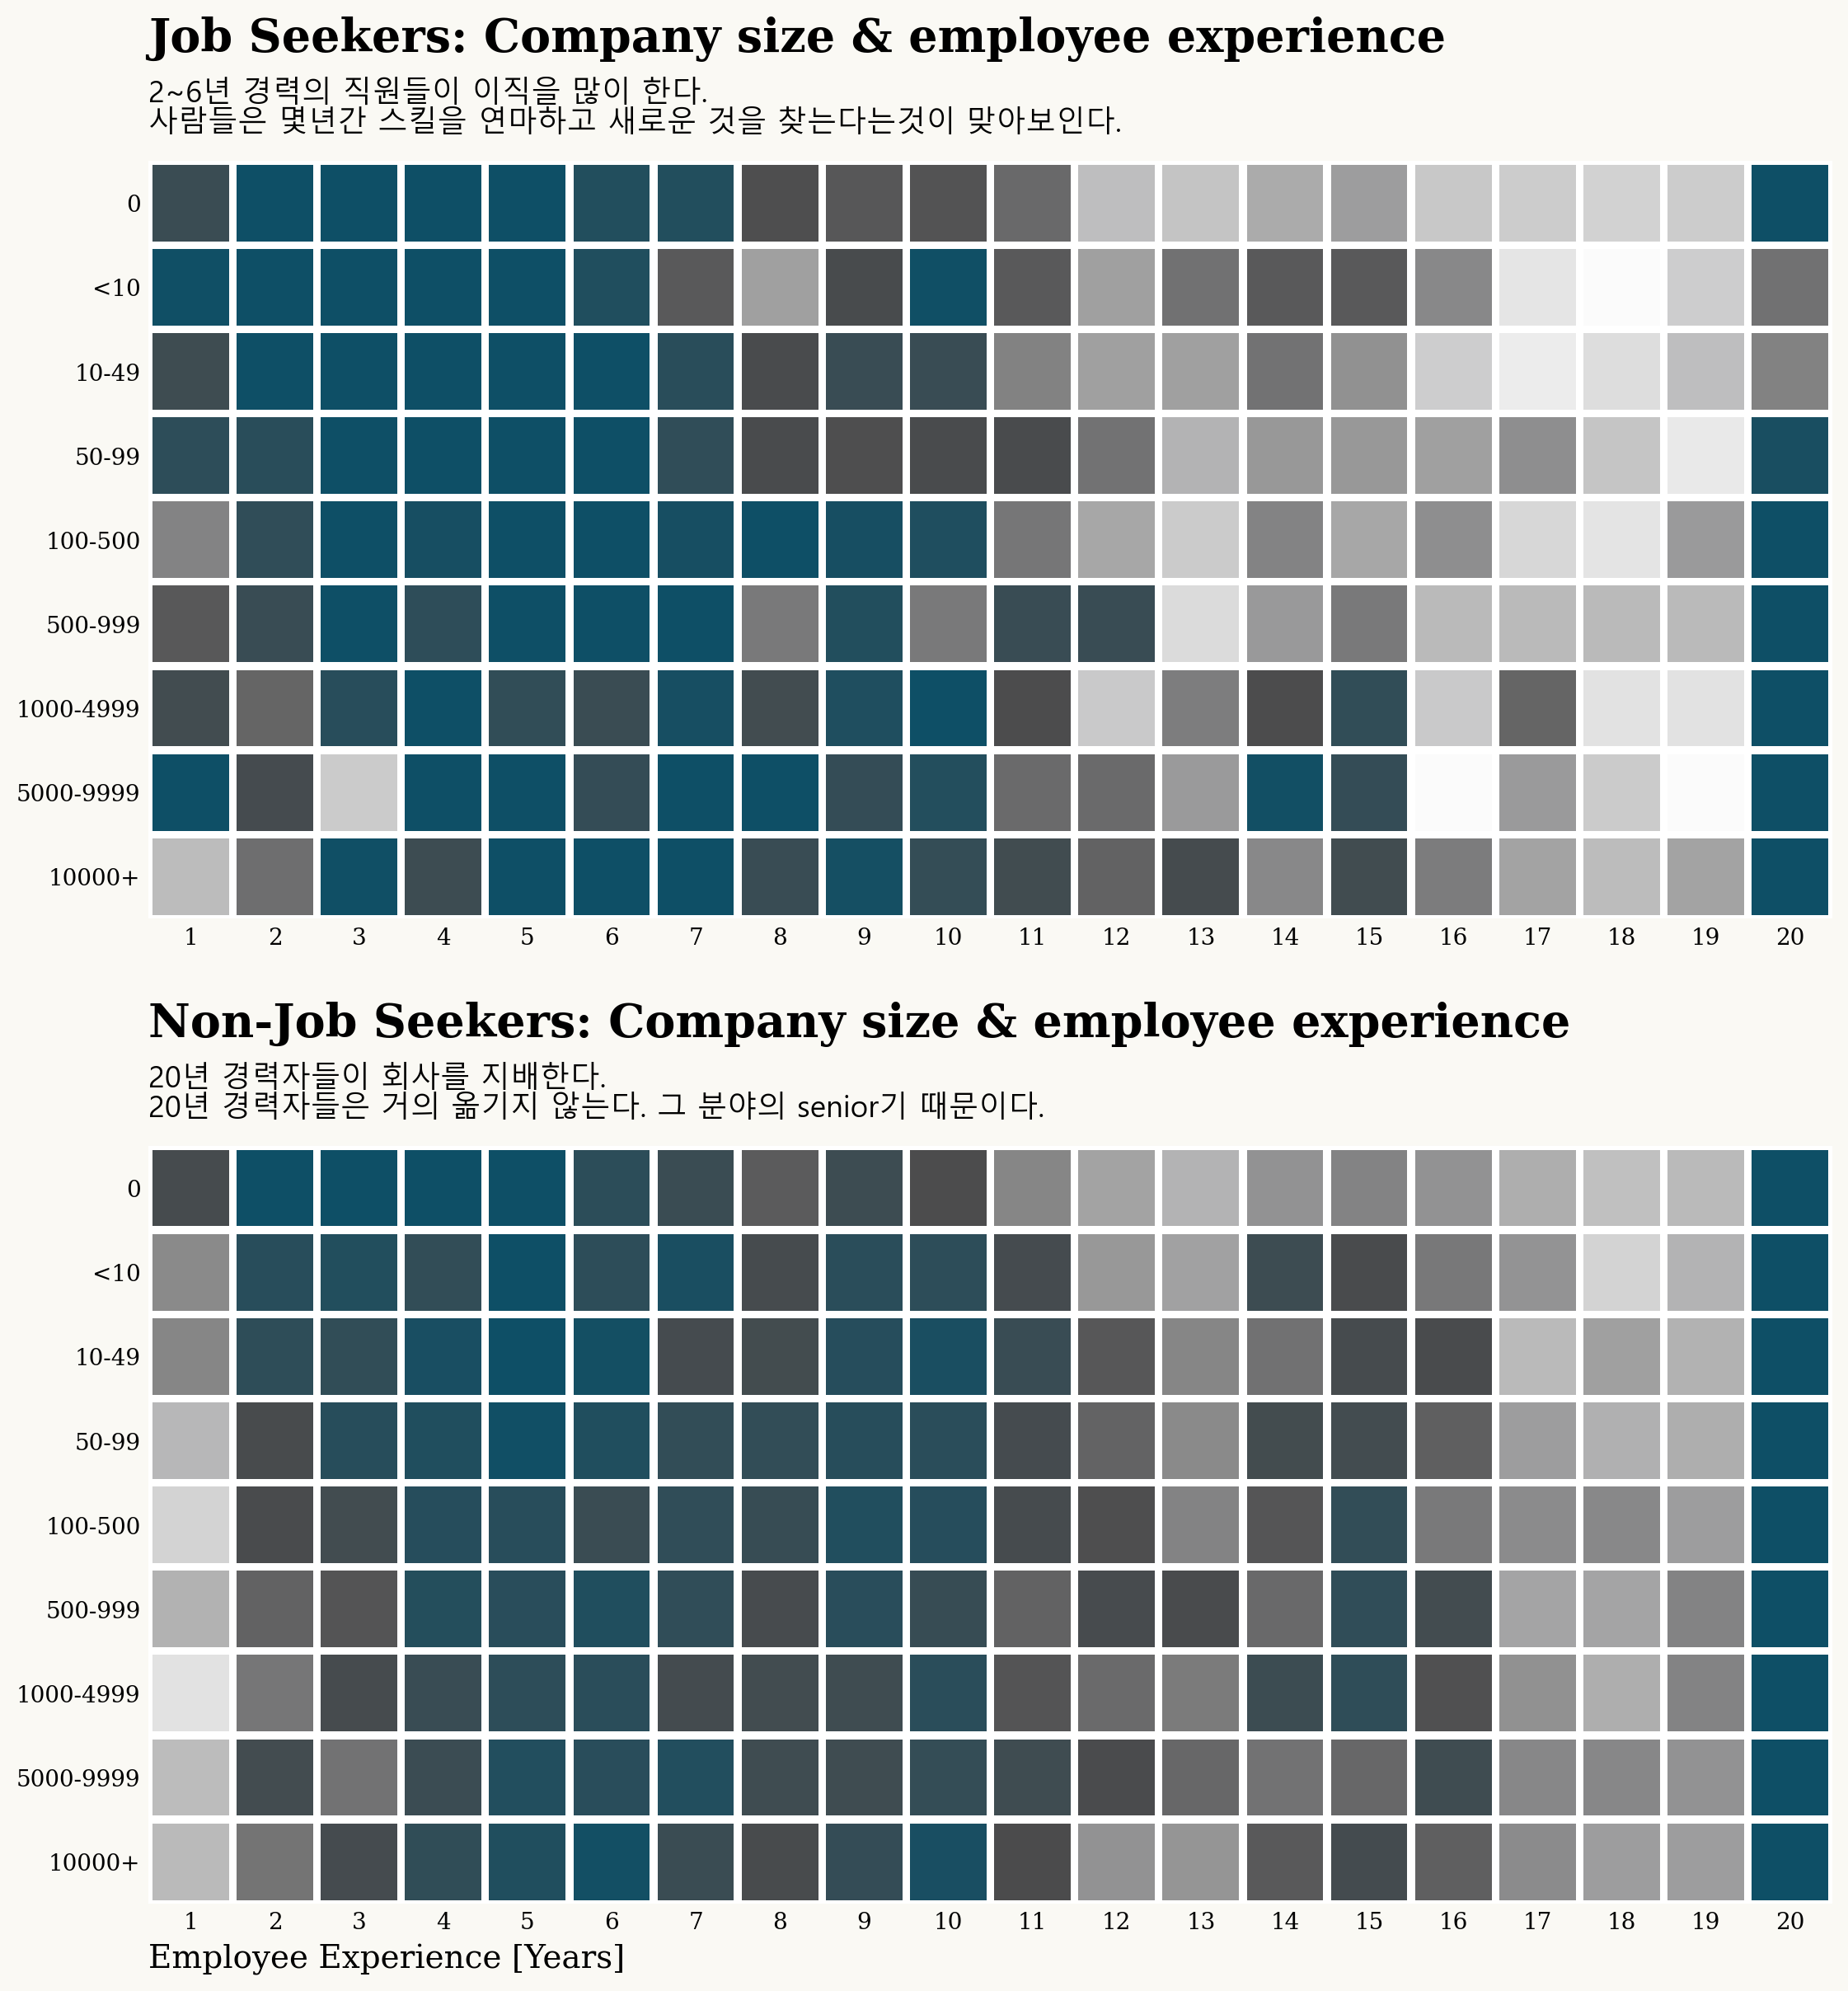

In [14]:

job_hunt_only = aug_train[aug_train['target']==1]
no_job_hunt_only = aug_train[aug_train['target']==0]

job_seek = pd.crosstab(job_hunt_only['company_size'],job_hunt_only['experience'], normalize='index').loc[size_order,exp_yrs_order_2]
no_seek = pd.crosstab(no_job_hunt_only['company_size'],no_job_hunt_only['experience'], normalize='index').loc[size_order,exp_yrs_order_2]

###
fig = plt.figure(figsize=(14,14))
gs = fig.add_gridspec(2, 3)
gs.update(wspace=0.2, hspace=0.3)
ax0 = fig.add_subplot(gs[0,:])
ax1 = fig.add_subplot(gs[1,:])


colors = ["#fbfbfb", "#4b4b4c","#0e4f66"]
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

sns.heatmap(ax=ax0, data=job_seek, linewidths=.1, vmin=0, vmax=0.075,
            square=True, cbar_kws={"orientation": "horizontal"}, cbar=False, cmap=colormap,linewidth=3, annot=False, fmt='1.0%',annot_kws={"fontsize":14})

sns.heatmap(ax=ax1, data=no_seek, linewidths=.1, vmin=0, vmax=0.075,
            square=True, cbar_kws={"orientation": "horizontal"}, cbar=False, cmap=colormap,linewidth=3, annot=False, fmt='1.0%',annot_kws={"fontsize":14})


# Change background color
background_color = "#fbfbfb"
fig.patch.set_facecolor(background_color) # figure background color
ax0.set_facecolor(background_color) # axes background color

ax0.set_xlabel("")
ax0.set_ylabel("")

for s in ["top","right","left"]:
    ax0.spines[s].set_visible(False)

    
    # Change background color
background_color = "#faf9f4"
fig.patch.set_facecolor(background_color) # figure background color
ax0.set_facecolor(background_color) # axes background color

ax0.set_xlabel("")
ax0.set_ylabel("")
ax1.set_xlabel("Employee Experience [Years]",fontfamily='serif',fontsize=14,loc='left')
ax1.set_ylabel("")

for s in ["top","right","left"]:
    ax0.spines[s].set_visible(False)
    ax1.spines[s].set_visible(False)

    
ax0.text(0, -1.3, 
         'Job Seekers: Company size & employee experience', 
         fontsize=20, 
         fontweight='bold', 
         fontfamily='serif',
        )

ax1.text(0, -0.7, 
         '20년 경력자들이 회사를 지배한다.', 
         fontsize=13, 
         fontweight='light', 
         fontproperties=fontprop,
        )
ax1.text(0, -0.35, 
         '20년 경력자들은 거의 옮기지 않는다. 그 분야의 senior기 때문이다.', 
         fontsize=13, 
         fontweight='light', 
         fontproperties=fontprop,
        )
    
ax1.text(0, -1.3, 
         'Non-Job Seekers: Company size & employee experience', 
         fontsize=20, 
         fontweight='bold', 
         fontfamily='serif',
        )

ax0.text(0, -0.7, 
         '2~6년 경력의 직원들이 이직을 많이 한다.', 
         fontsize=13, 
         fontweight='light', 
         fontproperties=fontprop,
        )
ax0.text(0, -0.35, 
         '사람들은 몇년간 스킬을 연마하고 새로운 것을 찾는다는것이 맞아보인다.', 
         fontsize=13, 
         fontweight='light', 
         fontproperties=fontprop,
        )

ax0.tick_params(axis=u'both', which=u'both',length=0)
ax1.tick_params(axis=u'both', which=u'both',length=0)

# Education

employee experience와 company size를 포함해서 흥미로운 변수들을 봤다. 

education과 연계해서 보겠다.

job-seekers는 교육수준이 높은가? 적은가? 차이가 있는가?


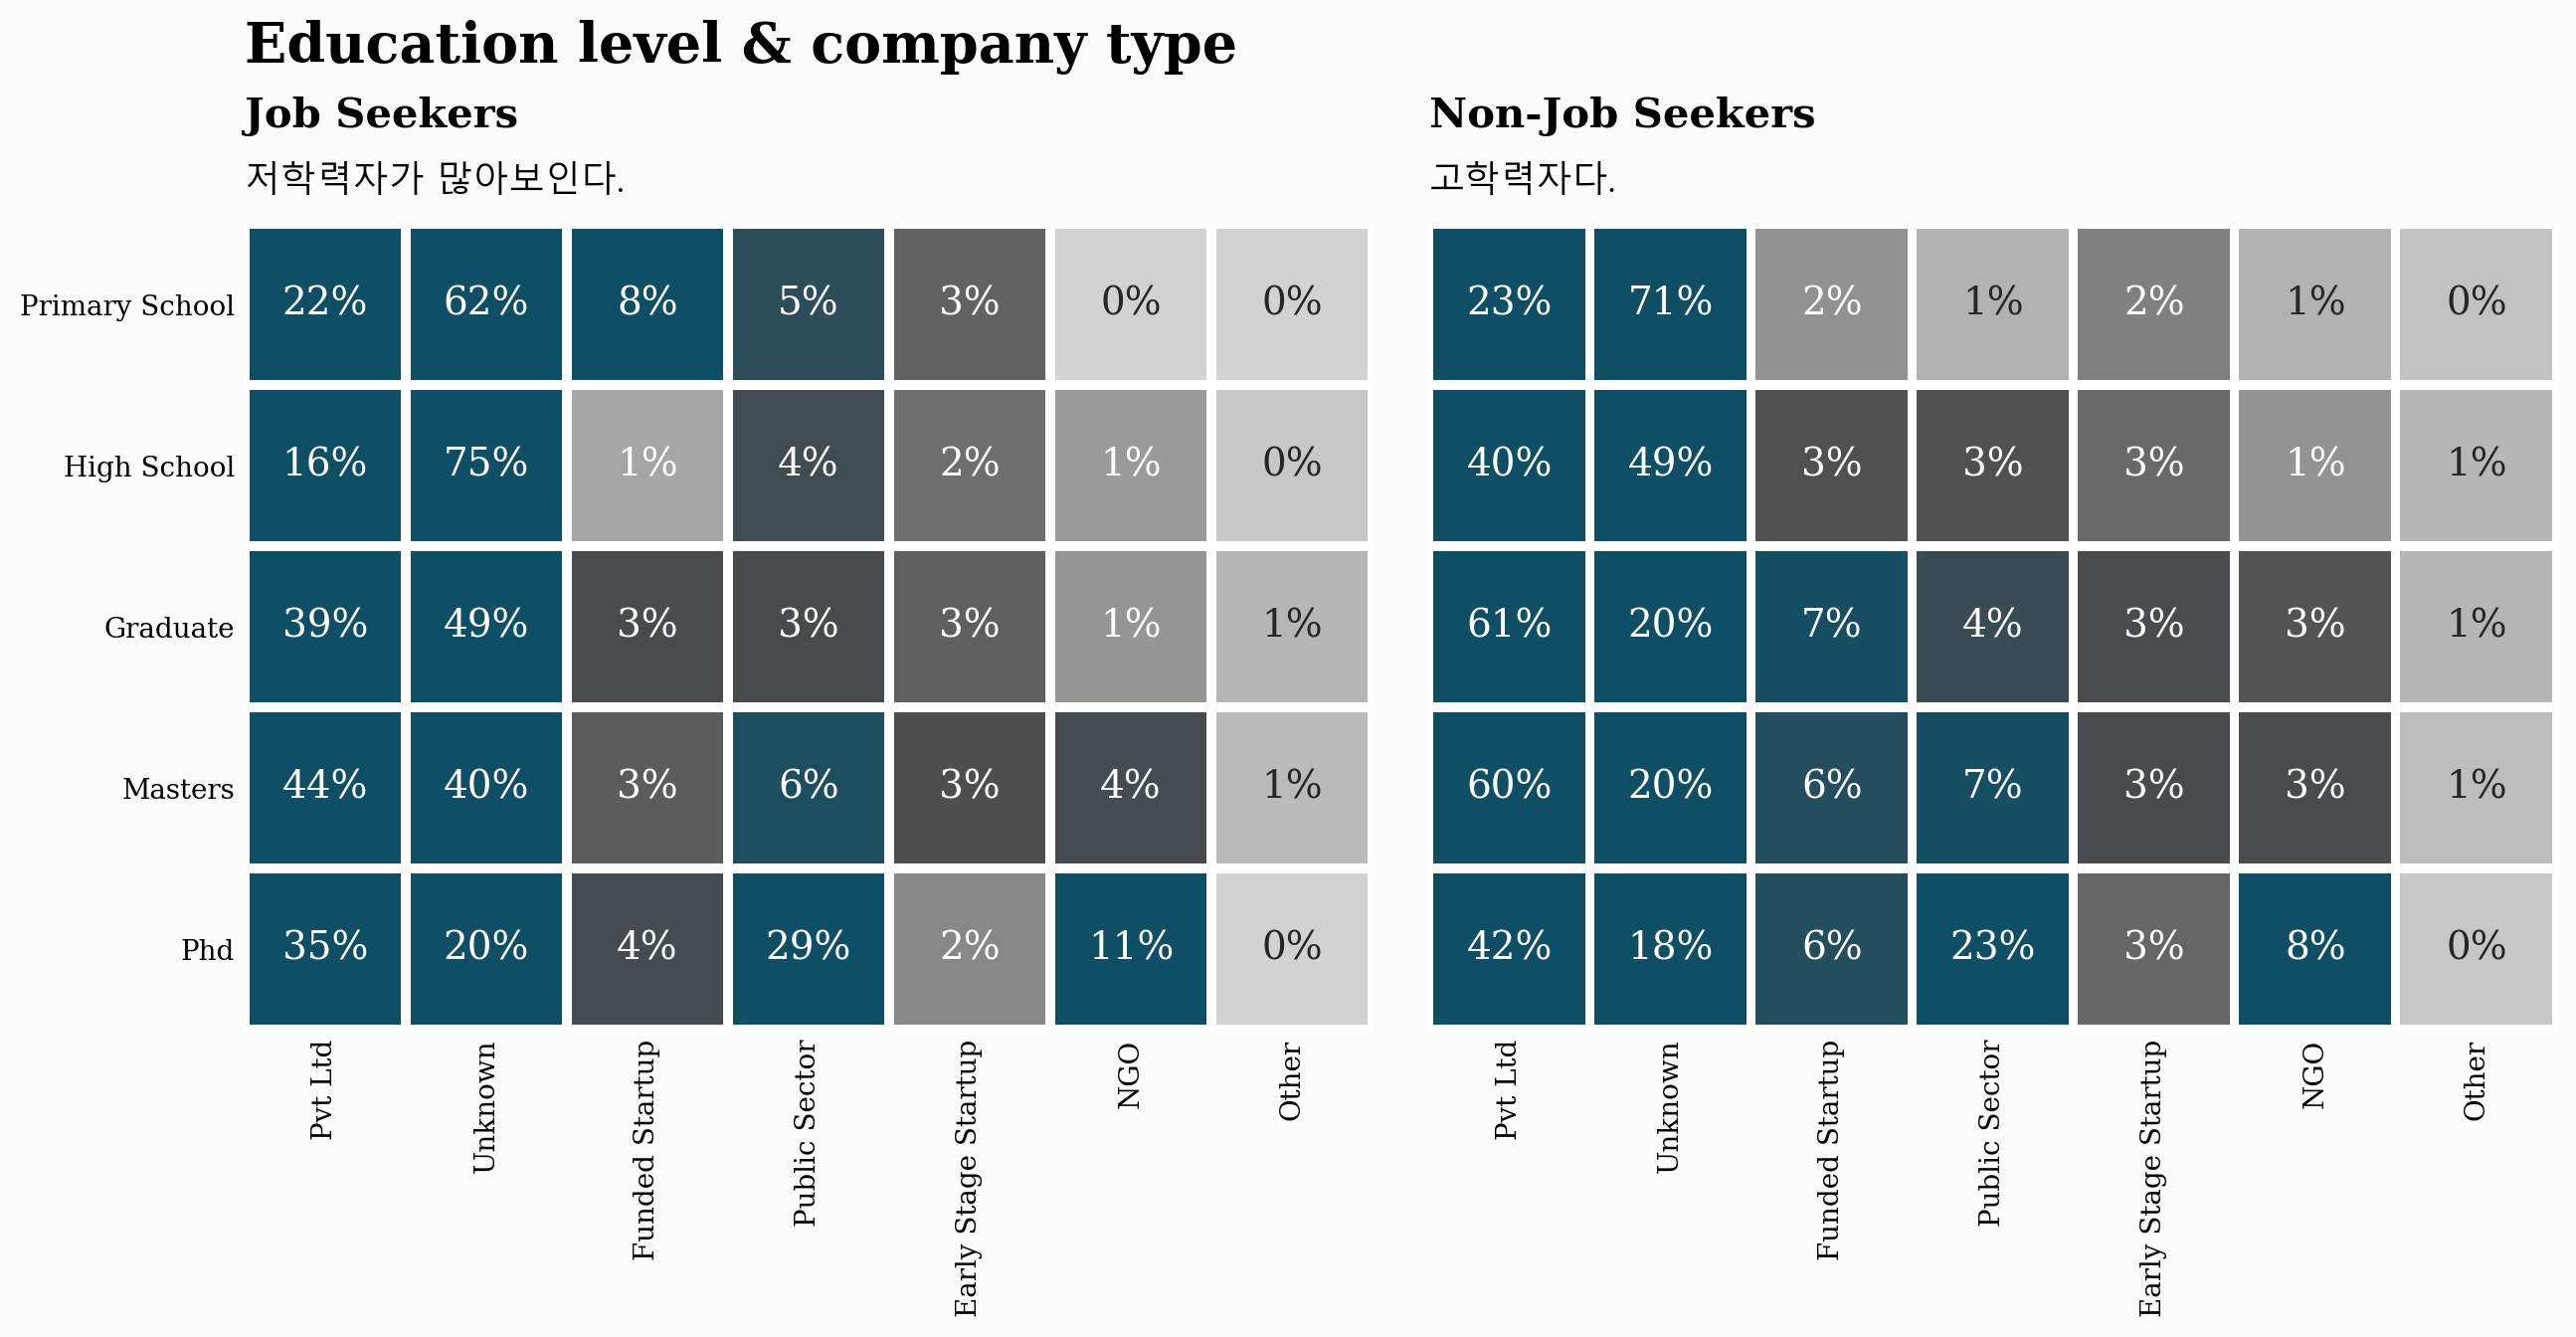

In [15]:
job_hunt_only = aug_train[aug_train['target']==1]
no_job_hunt_only = aug_train[aug_train['target']==0]

company_order
job_seek = pd.crosstab(job_hunt_only['education_level'],job_hunt_only['company_type'], normalize='index').loc[ed_order,company_order]
no_seek = pd.crosstab(no_job_hunt_only['education_level'],no_job_hunt_only['company_type'], normalize='index').loc[ed_order,company_order]

###
###
fig = plt.figure(figsize=(15,15))
gs = fig.add_gridspec(1, 2)
gs.update(wspace=0.05, hspace=0.3)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])


colors = ["#fbfbfb", "#4b4b4c","#0e4f66"]
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

sns.heatmap(ax=ax0, data=job_seek, linewidths=.1, vmin=-0.01, vmax=0.075,
            square=True, cbar_kws={"orientation": "horizontal"}, cbar=False, cmap=colormap,linewidth=3, annot=True, fmt='1.0%',annot_kws={"fontsize":14})

sns.heatmap(ax=ax1, data=no_seek, linewidths=.1, vmin=-0.01, vmax=0.075,
            square=True, cbar_kws={"orientation": "horizontal"}, cbar=False,yticklabels=False, cmap=colormap,linewidth=3, annot=True, fmt='1.0%',annot_kws={"fontsize":14})


# Change background color
background_color = "#fbfbfb"
fig.patch.set_facecolor(background_color) # figure background color
ax0.set_facecolor(background_color) # axes background color

ax0.set_xlabel("")
ax0.set_ylabel("")

for s in ["top","right","left"]:
    ax0.spines[s].set_visible(False)

ax0.set_xlabel("")
ax0.set_ylabel("")
ax1.set_xlabel("")
ax1.set_ylabel("")

for s in ["top","right","left"]:
    ax0.spines[s].set_visible(False)
    ax1.spines[s].set_visible(False)
    
    
ax0.text(0, -1, 
         'Education level & company type', 
         fontsize=20, 
         fontweight='bold', 
         fontfamily='serif',
        )

ax0.text(0, -0.6, 
         'Job Seekers', 
         fontsize=15, 
         fontweight='bold', 
         fontfamily='serif',
        )

ax0.text(0, -0.2, 
         '저학력자가 많아보인다.', 
         fontsize=13, 
         fontweight='light', 
         fontproperties=fontprop,
        )


ax1.text(0, -0.6, 
         'Non-Job Seekers', 
         fontsize=15, 
         fontweight='bold', 
         fontfamily='serif',
        )
ax1.text(0, -0.2, 
         '고학력자다.', 
         fontsize=13, 
         fontweight='light', 
         fontproperties=fontprop,
        )
    

ax0.tick_params(axis=u'both', which=u'both',length=0)
ax1.tick_params(axis=u'both', which=u'both',length=0)


흥미롭다. 이것은 이직자가 거의 저학력자로 보인다. 그들이 젊고 아직 교육 여정에 있으며 새로운 도전을 찾고 있기 때문이라고 생각한다.

어떻게 생각하나?

In [16]:
# Orders

ed_order = ['Primary School','High School','Graduate','Masters','Phd']
enroll_order = ['No Enrollment','Part time course','Full time course']
disc_order = ['STEM','Unknown','Humanities','Other','Business Degree','Arts','No Major']
exp_yrs_order = ['<1','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','>20']
size_order = ['0','<10', '10-49', '50-99', '100-500', '500-999', '1000-4999', '5000-9999', '10000+']
job_order = ['Never', '1', '2', '3', '4', '>4']
exp_order =['No relevant experience','Has relevant experience']
gender_order = ['Male','Female','Other','Not provided']
company_order = ['Pvt Ltd','Unknown','Funded Startup','Public Sector','Early Stage Startup','NGO','Other']



In [17]:
data = train_df
data['count'] = 1

data_ca = pd.pivot_table(data, values='count', index=['major_discipline'], columns=['company_size'], aggfunc=np.sum).fillna(0).astype(int).stack().loc[disc_order, size_order]
data_ca_man = pd.pivot_table(data[data['target']==1], values='count', index=['major_discipline'], columns=['company_size'], aggfunc=np.sum).fillna(0).astype(int).stack().loc[disc_order, size_order]
data_ca_woman = pd.pivot_table(data[data['target']==0], values='count', index=['major_discipline'], columns=['company_size'], aggfunc=np.sum).fillna(0).astype(int).stack().loc[disc_order, size_order]

In [18]:
# https://stackoverflow.com/questions/56337732/how-to-plot-scatter-pie-chart-using-matplotlib
def drawPieMarker(xs, ys, ratios, sizes, colors, ax):
    markers = []
    previous = 0
    # calculate the points of the pie pieces
    for color, ratio in zip(colors, ratios):
        this = 2 * np.pi * ratio + previous
        x  = [0] + np.cos(np.linspace(previous, this, 30)).tolist() + [0]
        y  = [0] + np.sin(np.linspace(previous, this, 30)).tolist() + [0]
        xy = np.column_stack([x, y])
        previous = this
        markers.append({'marker':xy, 's':np.abs(xy).max()**2*np.array(sizes), 'facecolor':color})

    # scatter each of the pie pieces to create pies
    for marker in markers:
        ax.scatter(xs, ys, **marker, alpha=0.9)

# Going Deeper

이 plot은 정확하지 않다. 하지만, 많은 정보를 한눈에 볼 수 있게 해준다. 독자들로 하여금 생각하게 한다.

대다수의 직원은 STEM 졸업생이다. 이 졸업생들은 또한 모든 회사 규모에서 매우 잘 표현된다.

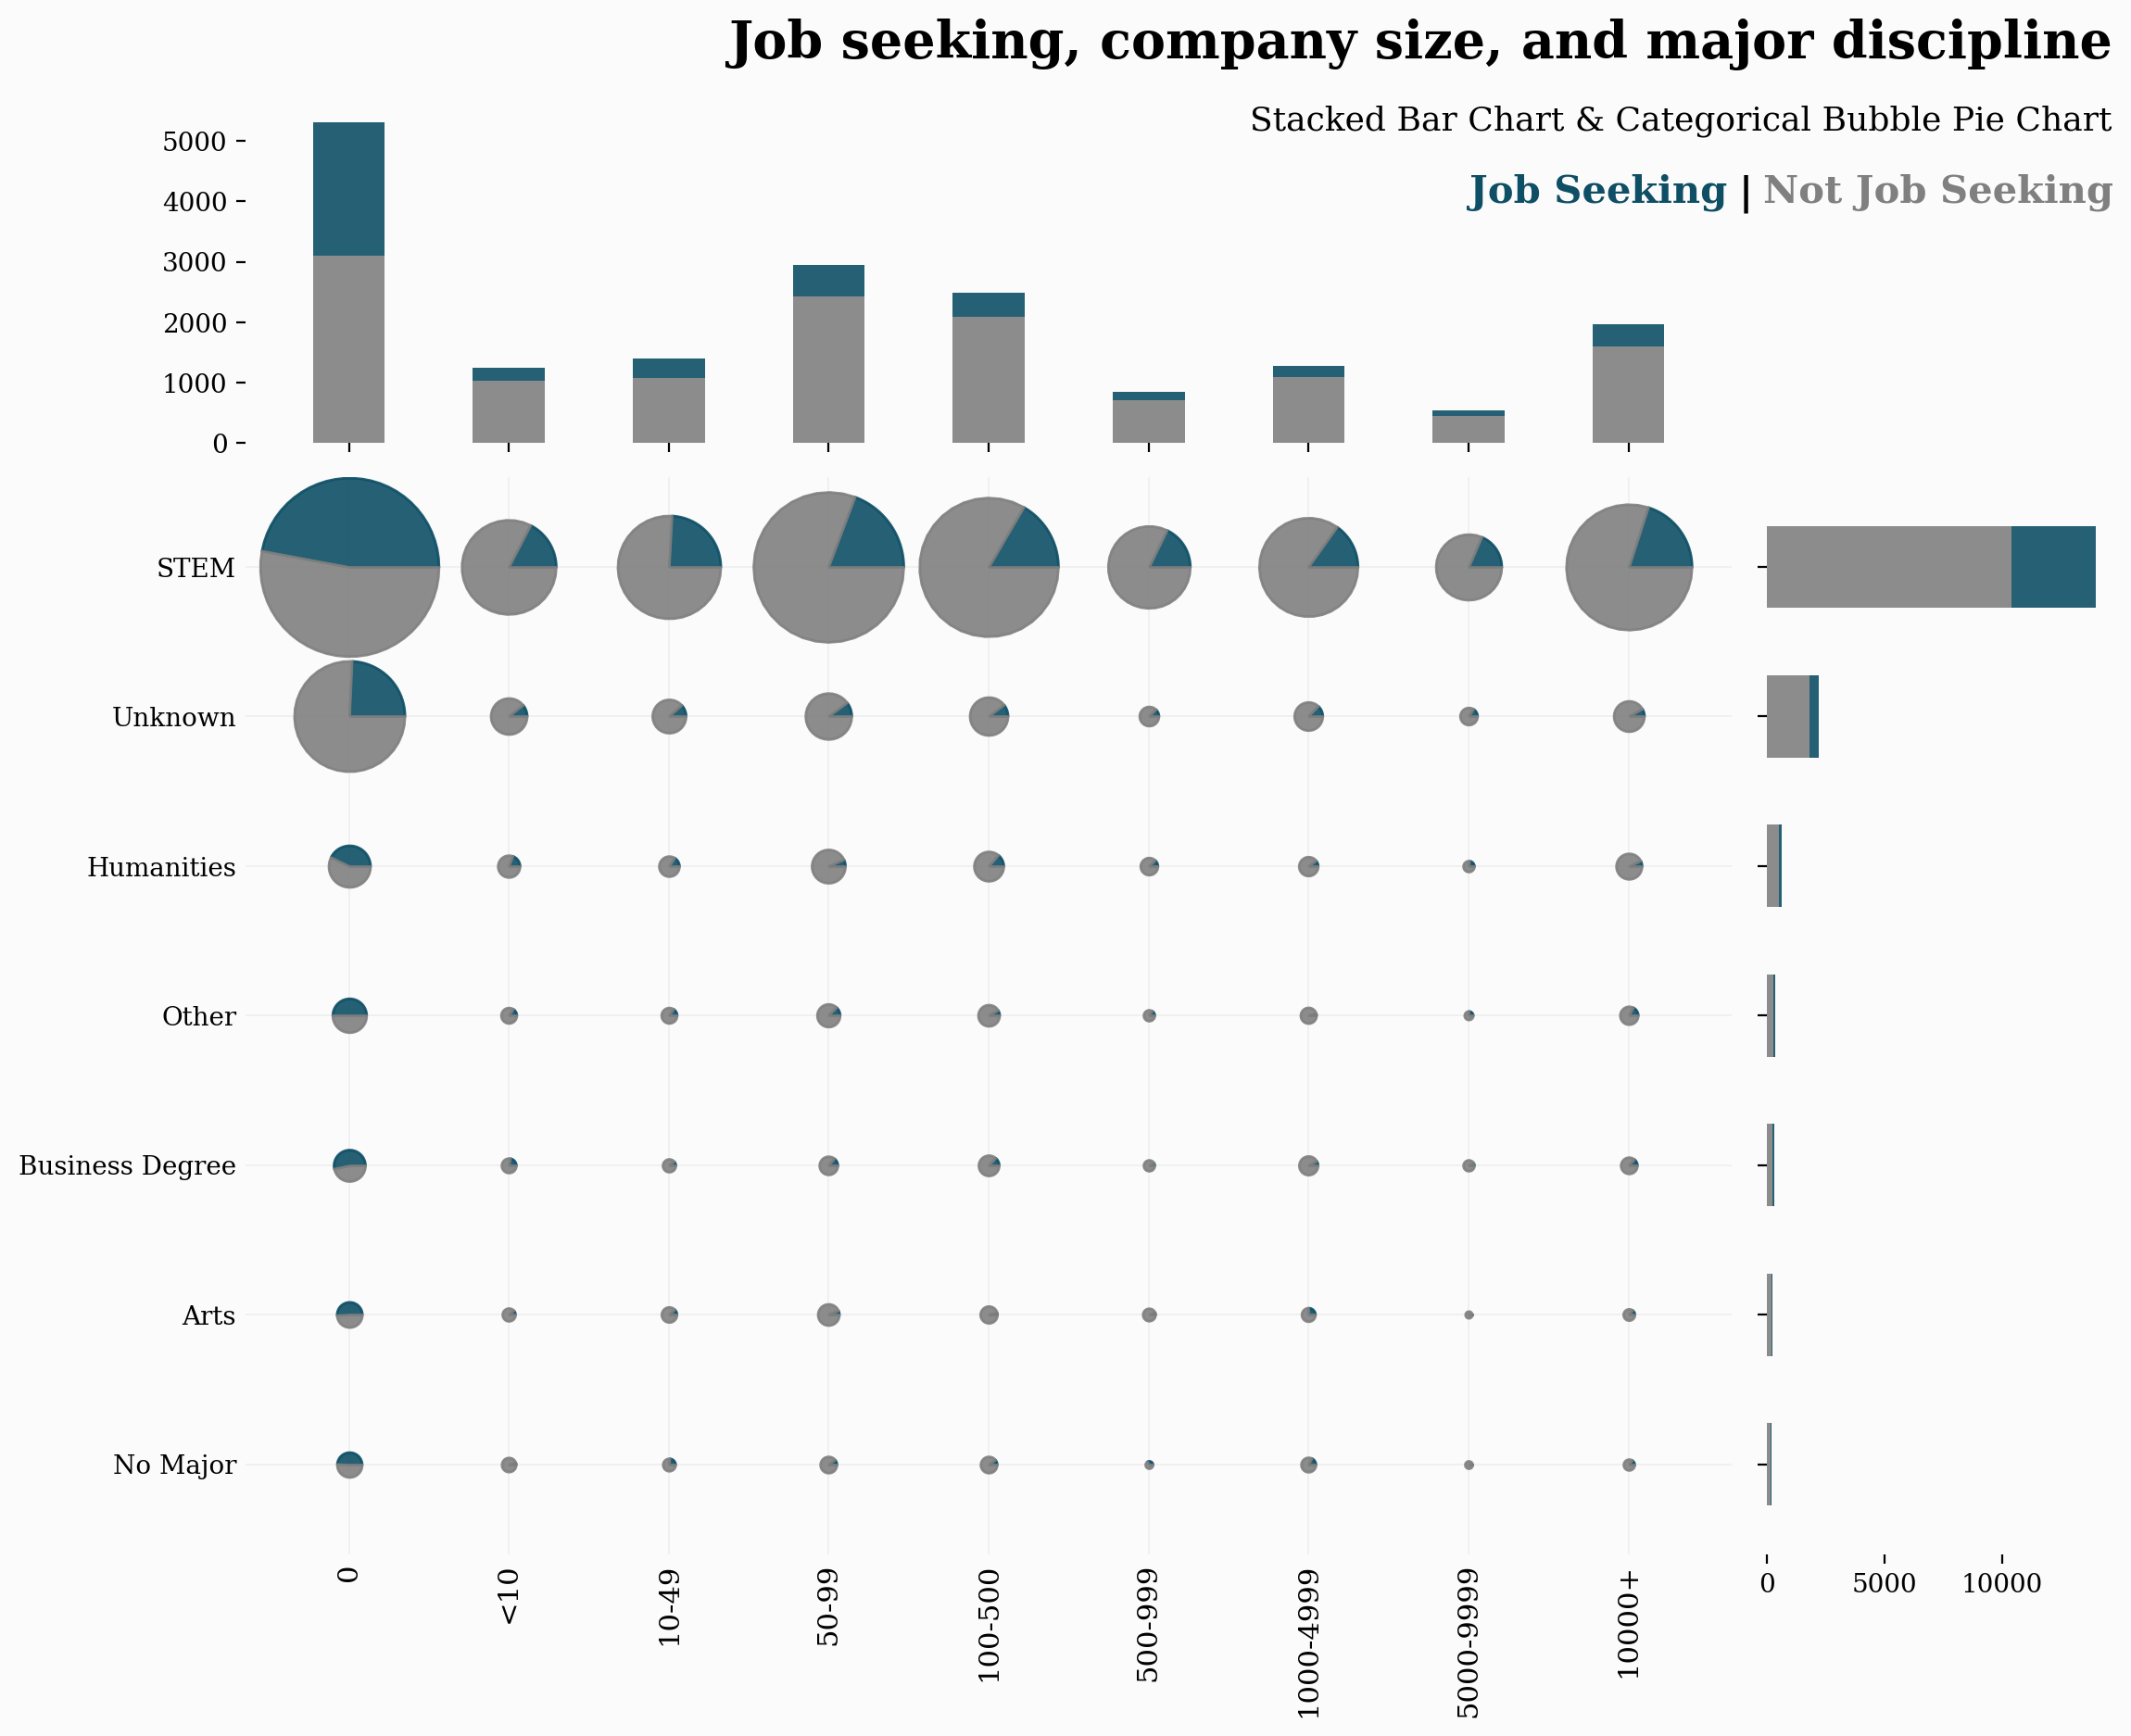

In [19]:
# Plot inspires by Subin An

fig = plt.figure(figsize=(13, 13))

gs = fig.add_gridspec(5, 5)
gs.update(wspace=0.1, hspace=0.1)


# Change background color
background_color = "#fbfbfb"
fig.patch.set_facecolor(background_color) # figure background color
#ax.set_facecolor(background_color) # axes background color



# Pie charts

ax_plot = fig.add_subplot(gs[1:4, 0:4]) 
for cl_idx in disc_order[::-1]:
    for age_idx in size_order:
        man = data_ca_man[cl_idx][age_idx]
        woman = data_ca_woman[cl_idx][age_idx]
        tot = data_ca[cl_idx][age_idx]
        drawPieMarker([age_idx],[cl_idx], [man/(man+woman), woman/(man+woman)] ,[tot*1.4], ["#0e4f66", "gray"], ax=ax_plot)

ax_plot.grid(linewidth=0.1)        
ax_plot.set_facecolor(background_color)
ax_plot.set_xticklabels(size_order,fontfamily='serif', fontsize=11, rotation=90)

 # Top
ax_pos = fig.add_subplot(gs[0, :4], sharex=ax_plot) 
data_age_woman = data[data['target']==0]['company_size'].value_counts()[size_order]
ax_pos.bar(data_age_woman.index, data_age_woman, width=0.45, alpha=0.9, color='gray')

data_age_man = data[data['target']==1]['company_size'].value_counts()[size_order]
ax_pos.bar(data_age_man.index, data_age_man, bottom=data_age_woman , width=0.45, alpha=0.9, color='#0e4f66')

plt.setp(ax_pos.get_xticklabels(), visible=False)
ax_pos.set_facecolor(background_color)

# Side 
ax_exp = fig.add_subplot(gs[1:4, 4], sharey=ax_plot) 

data_cl_woman = data[data['target']==0]['major_discipline'].value_counts()[disc_order]
ax_exp.barh(data_cl_woman.index[::-1], data_cl_woman[::-1], height=0.55, alpha=0.9, color='gray')

data_cl_man = data[data['target']==1]['major_discipline'].value_counts()[disc_order]
ax_exp.barh(data_cl_man.index[::-1], data_cl_man[::-1], left= data_cl_woman[::-1],height=0.55, alpha=0.9, color='#0e4f66')

plt.setp(ax_exp.get_yticklabels(), visible=False)
ax_exp.set_facecolor(background_color)

# Spines
for s in ['top', 'left', 'right', 'bottom']:
    ax_plot.spines[s].set_visible(False)
    ax_pos.spines[s].set_visible(False)
    ax_exp.spines[s].set_visible(False)
ax_plot.set_axisbelow(True)    

fig.text(0.9, 0.9, 'Job seeking, company size, and major discipline', fontweight='bold', fontfamily='serif', fontsize=20, ha='right') 
fig.text(0.9, 0.87, 'Stacked Bar Chart & Categorical Bubble Pie Chart', fontweight='light', fontfamily='serif', fontsize=13, ha='right')

fig.text(0.633,0.84,"Job Seeking", fontweight="bold", fontfamily='serif', fontsize=15, color='#0e4f66')
fig.text(0.745,0.84,"|", fontweight="bold", fontfamily='serif', fontsize=15, color='black')
fig.text(0.755,0.84,"Not Job Seeking", fontweight="bold", fontfamily='serif', fontsize=15, color='gray')

ax_plot.tick_params(axis=u'both', which=u'both',length=0)



plt.tight_layout()
plt.show()

In [20]:

ed_order = ['Primary School','High School','Graduate','Masters','Phd']
enroll_order = ['No Enrollment','Part time course','Full time course']
disc_order = ['STEM','Unknown','Humanities','Other','Business Degree','Arts','No Major']
exp_yrs_order = ['<1','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','>20']
exp_yrs_order_2 = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
size_order = ['0','<10', '10-49', '50-99', '100-500', '500-999', '1000-4999', '5000-9999', '10000+']
job_order = ['Never', '1', '2', '3', '4', '>4']
exp_order =['No relevant experience','Has relevant experience']
gender_order = ['Male','Female','Other','Not provided']



In [21]:
job_change = aug_train.groupby(['education_level','last_new_job'])['experience'].sum().unstack().loc[ed_order,job_order]
jc_never = job_change['Never']
job_change

job_change_norm = pd.crosstab(aug_train['education_level'],aug_train['last_new_job'],normalize='columns').loc[ed_order,job_order,]
job_change_norm = round(job_change_norm*100,1).astype(int)
job_change_norm



##
job_hunt_only = aug_train[aug_train['target']==1]
no_job_hunt_only = aug_train[aug_train['target']==0]


seekers_job_change_norm = pd.crosstab(job_hunt_only['education_level'],job_hunt_only['last_new_job'],normalize='columns').loc[ed_order,job_order,]
seekers_job_change_norm = round(seekers_job_change_norm*100,1).astype(int)
seekers_job_change_norm

non_seekers_job_change_norm = pd.crosstab(no_job_hunt_only['education_level'],no_job_hunt_only['last_new_job'],normalize='columns').loc[ed_order,job_order,]
non_seekers_job_change_norm = round(non_seekers_job_change_norm*100,1).astype(int)


# Prediction

이 notebook의 주 목적은 시각화이지만, 마지막으로 예측모델을 선택하는 과정과 함께 과정을 끝낼 것이다.

fine-tune 하는데 시간을 쓰지 않을 것이다. 하지만, 꽤 괜찮은 결과를 얻을 것이다. 결과또한 시각화 할것이다.


In [22]:
# Extra libs

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, precision_score
from sklearn.svm import LinearSVC


In [23]:
list_of_columns = ['city', 'gender', 'relevent_experience', 'enrolled_university', 'education_level',
                   'major_discipline', 'experience', 'company_size', 'company_type', 'last_new_job']

aug_train_dummies_df = []

for col in list_of_columns:
    dummy_train_df = pd.get_dummies(aug_train[col])
    aug_train_dummies_df.append(dummy_train_df)


list_of_columns.append('enrollee_id')    
aug_train_dummies_df.insert(0, aug_train.drop(columns=list_of_columns))

aug_train = pd.concat(aug_train_dummies_df,axis=1)
aug_train = aug_train.drop('count', 1)

# Final look at our df
aug_train.head(3)

city_development_index  training_hours  target  city_1  city_10  city_100  \
0                   0.920              36     1.0       0        0         0   
1                   0.776              47     0.0       0        0         0   
2                   0.624              83     0.0       0        0         0   

   city_101  city_102  city_103  city_104  ...  Other  Public Sector  Pvt Ltd  \
0         0         0         1         0  ...      0              0        0   
1         0         0         0         0  ...      0              0        1   
2         0         0         0         0  ...      0              0        0   

   Unknown  1  2  3  4  >4  Never  
0        1  1  0  0  0   0      0  
1        0  0  0  0  0   1      0  
2        1  0  0  0  0   0      1  

[3 rows x 190 columns]

# Exploring other dimensions

UMAP : 치수 감소를 위한 균일한 매니폴드 근사 및 투영 

UMAP은 차원축소기법으로 시각적으로 t-SNE과 비슷해보이지만 비선형 차원축소에도 사용된다.


이것은 독자들로 생각하게끔 하는 또 다른 plot이다. 

이것은  job-seekers와non-job-seekers 사이의 명백한 차이점을 보여준다.


In [24]:
from umap import UMAP

# Dimension Reduction
umap_target = aug_train['target'].values
data_sub = aug_train.drop(['target'], axis=1).fillna(0).values

umap = UMAP(random_state=0)
hr_umap = umap.fit_transform(data_sub, umap_target)



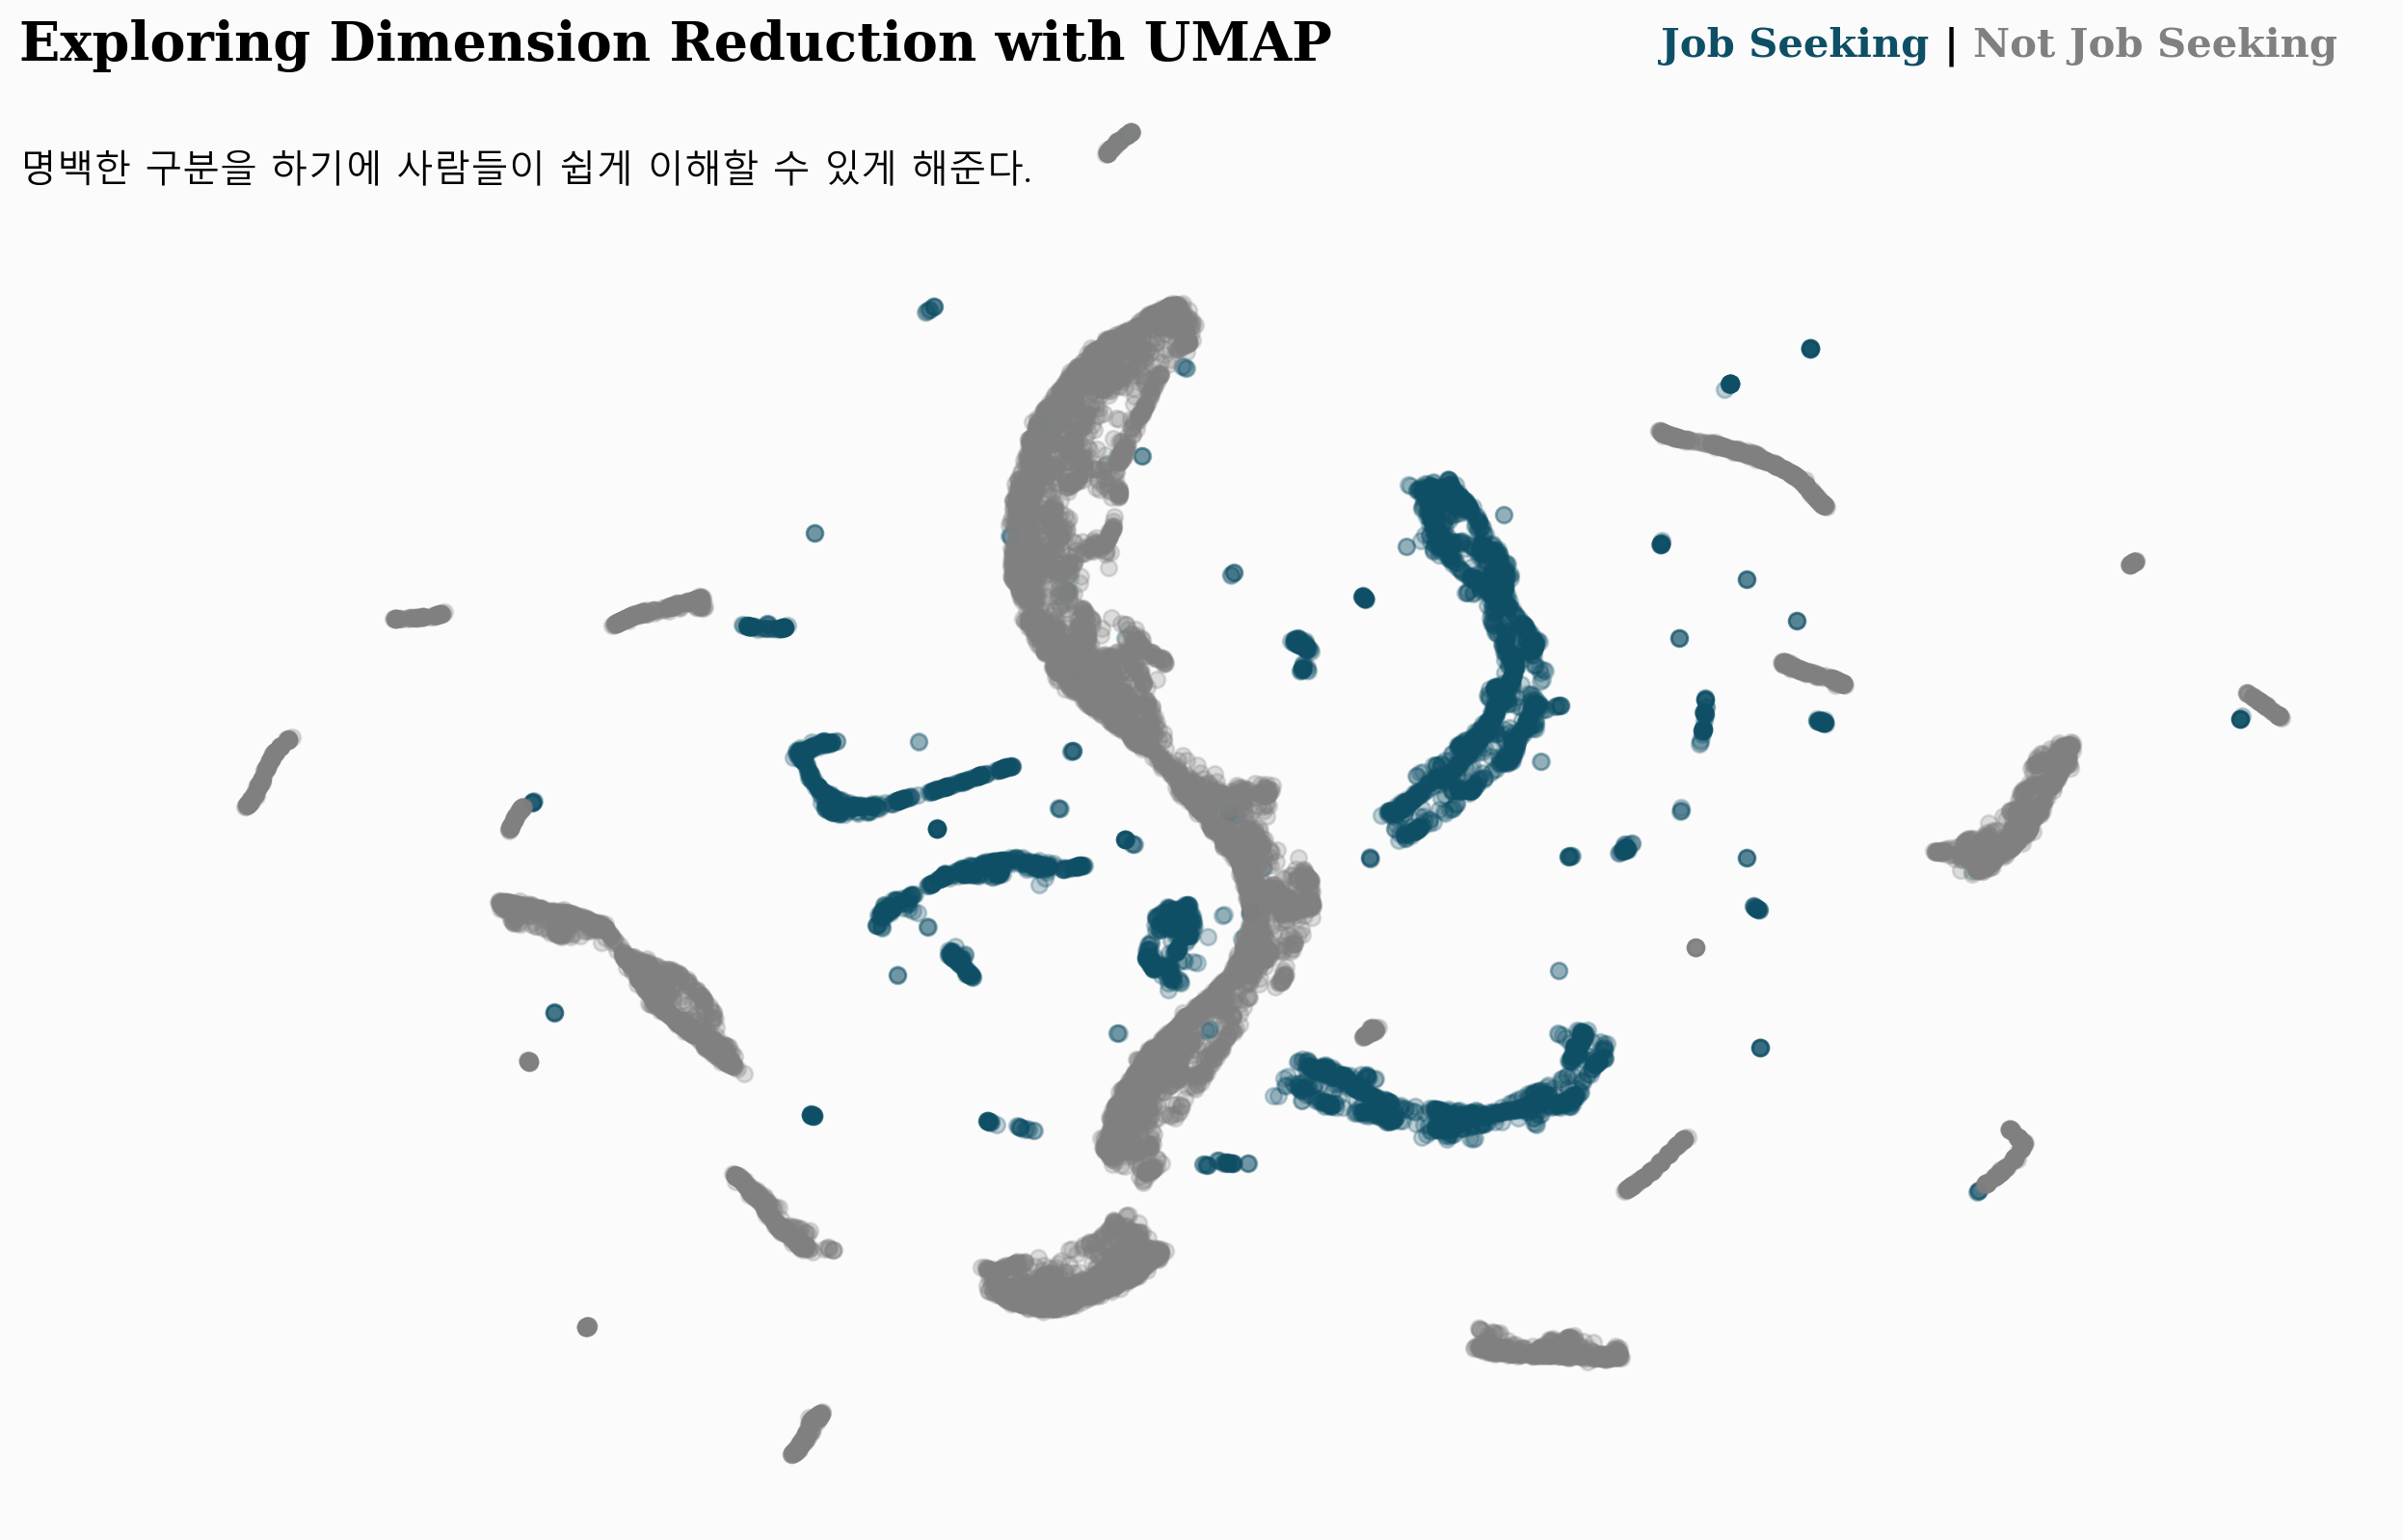

In [25]:
fig = plt.figure(figsize=(15,10)) # create figure
gs = fig.add_gridspec(1, 1)
gs.update(wspace=0.4, hspace=0.5)
ax0 = fig.add_subplot(gs[0, 0])



#ax0.grid(color='black', linestyle=':', axis='x', zorder=0,  dashes=(1,5))


# Change background color
background_color = "#fbfbfb"
fig.patch.set_facecolor(background_color) # figure background color
ax0.set_facecolor(background_color)

# Survived
ax0.scatter(hr_umap[aug_train['target']==1][:,0], hr_umap[aug_train['target']==1][:,1], c='#0e4f66', alpha=0.25, label='Survived:1')
ax0.scatter(hr_umap[aug_train['target']==0][:,0], hr_umap[aug_train['target']==0][:,1], c='gray', alpha=0.25, label='Survived:0')

ax0.text(-14, 16, '명백한 구분을 하기에 사람들이 쉽게 이해할 수 있게 해준다.',fontsize=14, fontproperties=fontprop)

ax0.text(-14, 19, 'Exploring Dimension Reduction with UMAP', 
         fontsize=20, fontweight='bold', fontfamily='serif')


for s in ["top","right","left","bottom"]:
    ax0.spines[s].set_visible(False)
    ax1.spines[s].set_visible(False)
    
ax0.set_xticks([])
ax0.set_yticks([])
ax1.set_xticks([])
ax1.set_yticks([])
fig.text(0.65,0.885,"Job Seeking", fontweight="bold", fontfamily='serif', fontsize=15, color='#0e4f66')
fig.text(0.748,0.885,"|", fontweight="bold", fontfamily='serif', fontsize=15, color='black')
fig.text(0.758,0.885,"Not Job Seeking", fontweight="bold", fontfamily='serif', fontsize=15, color='gray')

plt.show()
    

# Modelling

이 문제를 몇개의 알고리즘들로 풀 것이다.


In [26]:
X = aug_train.dropna().drop(columns=['target']).values
y = aug_train.dropna()['target'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=80)


# Classification with a linear SVM
svc = LinearSVC(dual=False, random_state=123)
params_grid = {"C": [10 ** k for k in range(-3, 4)]}
clf = GridSearchCV(svc, params_grid)
clf.fit(X_train, y_train)
print(
    "Accuracy on the test set with raw data: {:.3f}".format(clf.score(X_test, y_test))
)

print(clf.best_params_)

Accuracy on the test set with raw data: 0.784
{'C': 0.1}


In [27]:


# Transformation with UMAP followed by classification with a linear SVM


#import umap

#umap_target = aug_train['target'].values
#data_sub = aug_train.drop(['target'], axis=1).fillna(0).values

#umap = UMAP(random_state=456)
#pipeline = Pipeline([("umap", umap), ("svc", svc)])
#params_grid_pipeline = {
#    "umap__n_neighbors": [5, 20],
#    "umap__n_components": [15, 25, 50],
#    "svc__C": [10 ** k for k in range(-3, 4)],
#}


#clf_pipeline = GridSearchCV(pipeline, params_grid_pipeline)
#clf_pipeline.fit(X_train, y_train)
#print(
#    "Accuracy on the test set with UMAP transformation: {:.3f}".format(
#        clf_pipeline.score(X_test, y_test)
#    )
#)


## output with default params is: "Accuracy on the test set with UMAP transformation: 0.759"

## Did not fine tune as took WAY TOO LONG on my computer. 


In [28]:
X = aug_train.dropna().drop(columns=['target']).values
y = aug_train.dropna()['target'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=80)

In [29]:
# Support Vector Machine (SVM / SVC)
pipeline = make_pipeline(StandardScaler(), SVC(kernel='sigmoid'))
pipeline.fit(X_train, y_train)
svc_prediction = pipeline.predict(X_test)
cm_svc = confusion_matrix(y_test, svc_prediction)
svc_df = pd.DataFrame(data=[accuracy_score(y_test, svc_prediction), recall_score(y_test, svc_prediction),
                   precision_score(y_test, svc_prediction), roc_auc_score(y_test, svc_prediction)], 
             columns=['SVC Score'],
             index=["Accuracy", "Recall", "Precision", "ROC AUC Score"])

In [30]:
# Basic Decision Tree
dtree = DecisionTreeClassifier()
dtree.fit(X_train,y_train)
dtree_prediction = dtree.predict(X_test)
cm_dtree = confusion_matrix(y_test, dtree_prediction)
dtree_df = pd.DataFrame(data=[accuracy_score(y_test, dtree_prediction), recall_score(y_test, dtree_prediction),
                   precision_score(y_test, dtree_prediction), roc_auc_score(y_test, dtree_prediction)], 
             columns=['Decision Tree Score'],
             index=["Accuracy", "Recall", "Precision", "ROC AUC Score"])

In [31]:
# Random Forest
rfc = RandomForestClassifier(n_estimators=600)
rfc.fit(X_train,y_train)
rfc_prediction = rfc.predict(X_test)
cm_rfc = confusion_matrix(y_test, rfc_prediction)
rfc_df = pd.DataFrame(data=[accuracy_score(y_test, rfc_prediction), recall_score(y_test, rfc_prediction),
                   precision_score(y_test, rfc_prediction), roc_auc_score(y_test, rfc_prediction)], 
             columns=['Random Forest Score'],
             index=["Accuracy", "Recall", "Precision", "ROC AUC Score"])

In [32]:
#param_grid = { 
#    'n_estimators': [ 500,800],
#    'max_features': ['auto', 'sqrt'],
#    'max_depth' : [7,8,9],
#    'criterion' :['gini', 'entropy']
#}

#CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
#CV_rfc.fit(X_train,y_train)
#CV_rfc.best_params_

In [33]:
# Tuned Random Forest
rfc1=RandomForestClassifier(random_state=0, n_estimators= 800, criterion = 'gini',max_features = 'auto',max_depth = 8)
rfc1.fit(X_train,y_train)
prediction_rf1= rfc1.predict(X_test)
cm_trfc = confusion_matrix(y_test, prediction_rf1)
trfc_df = pd.DataFrame(data=[accuracy_score(y_test, prediction_rf1), recall_score(y_test, prediction_rf1),
                   precision_score(y_test, prediction_rf1), roc_auc_score(y_test, prediction_rf1)], 
             columns=['Tuned Random Forest Score'],
             index=["Accuracy", "Recall", "Precision", "ROC AUC Score"])

In [34]:
#Logistic Regression
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)
log_prediction = logmodel.predict(X_test)
cm_log = confusion_matrix(y_test, log_prediction)
log_df = pd.DataFrame(data=[accuracy_score(y_test, log_prediction), recall_score(y_test, log_prediction),
                   precision_score(y_test, log_prediction), roc_auc_score(y_test, log_prediction)], 
             columns=['Logisitc Regression Score'],
             index=["Accuracy", "Recall", "Precision", "ROC AUC Score"])

In [35]:
X = aug_train.dropna().drop(columns=['target']).values
y = aug_train.dropna()['target'].values

scaler = StandardScaler()
scaler.fit(aug_train.drop('target',axis=1))
scaled_features = scaler.transform(aug_train.drop('target',axis=1))

# re split
X_train, X_test, y_train, y_test = train_test_split(scaled_features,aug_train['target'],
                                                    test_size=0.30)

In [36]:
# K-Nearest Neighbours (KNN)
# searched already to find optimal neighbours, removed from notebook as took a long time
knn = KNeighborsClassifier(n_neighbors=17)
knn.fit(X_train,y_train)
knn_prediction = knn.predict(X_test)
cm_knn = confusion_matrix(y_test, knn_prediction)
knn_df = pd.DataFrame(data=[accuracy_score(y_test, knn_prediction), recall_score(y_test, knn_prediction),
                   precision_score(y_test, knn_prediction), roc_auc_score(y_test, knn_prediction)], 
             columns=['KNN Score'],
             index=["Accuracy", "Recall", "Precision", "ROC AUC Score"])

# So far...

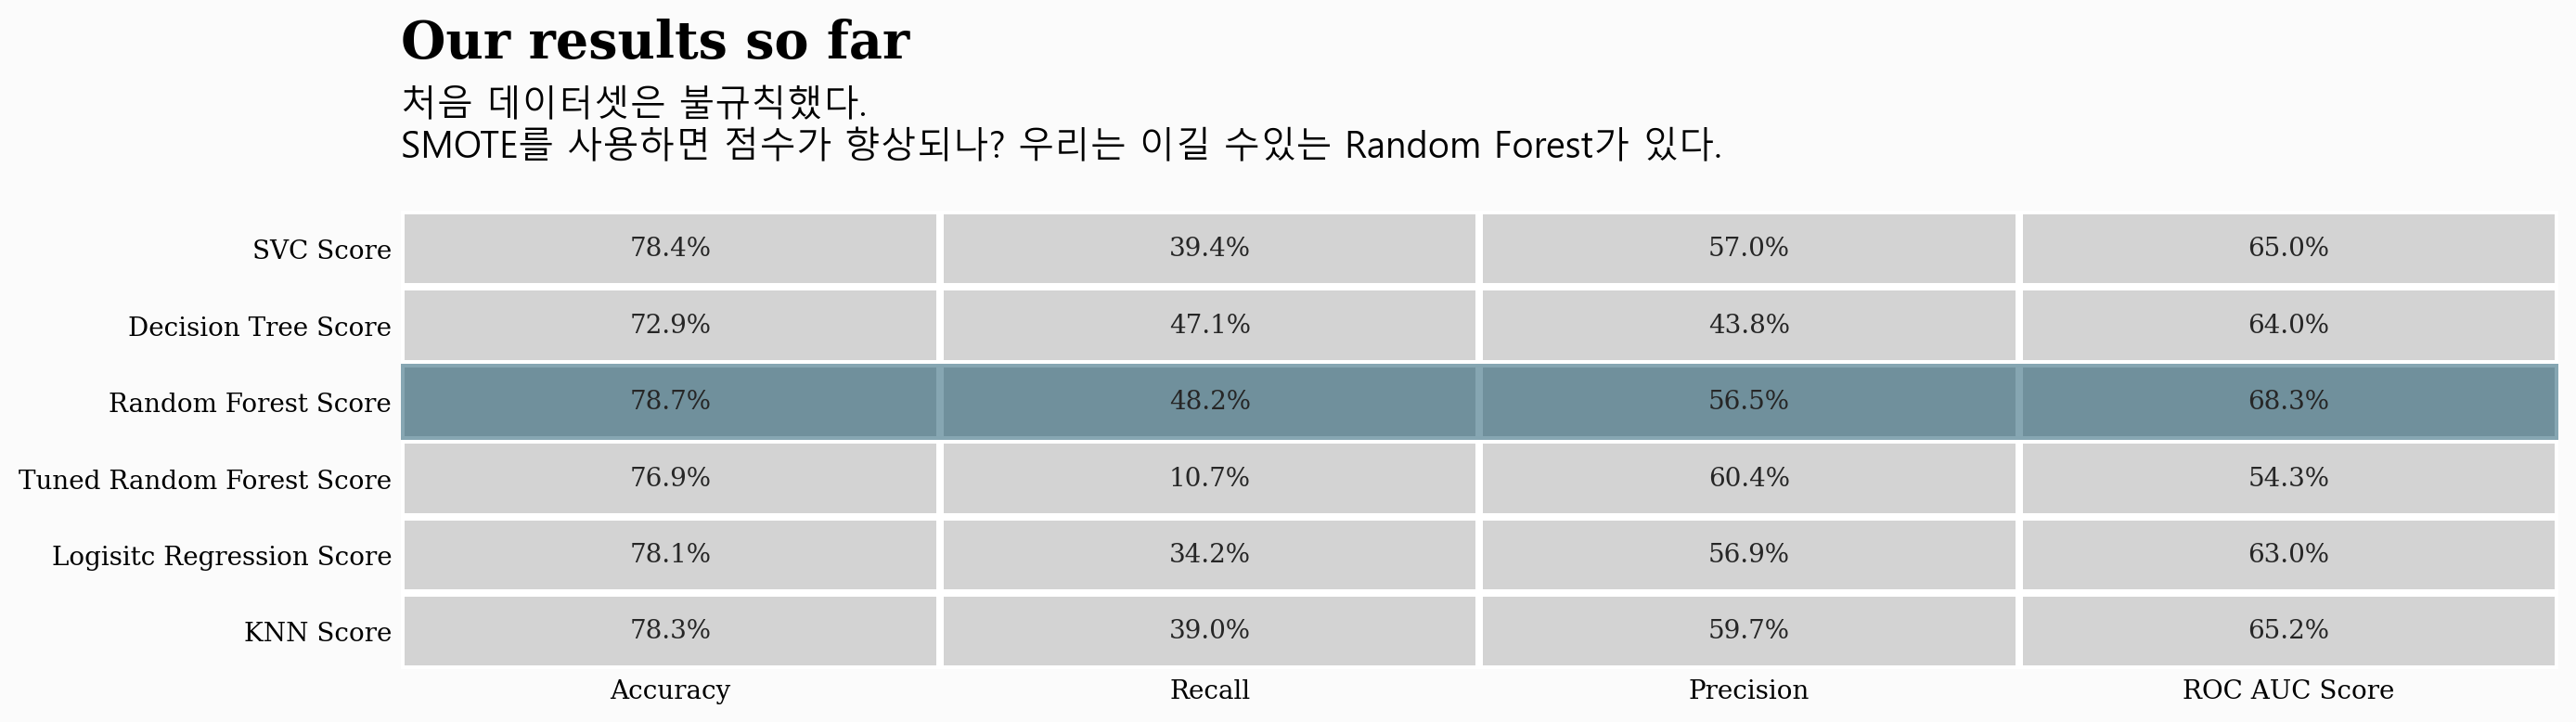

In [37]:
fig = plt.figure(figsize=(15,18)) # create figure
gs = fig.add_gridspec(4, 2)
gs.update(wspace=0.1, hspace=0.5)
ax0 = fig.add_subplot(gs[0, :])

colors = ["lightgray","lightgray"]
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
# Change background color
background_color = "#fbfbfb"
fig.patch.set_facecolor(background_color) # figure background color
ax0.set_facecolor(background_color)

# Overall
df_models = round(pd.concat([svc_df,dtree_df,rfc_df,trfc_df,log_df,knn_df], axis=1),3)
sns.heatmap(df_models.T, cmap=colormap,annot=True,fmt=".1%", linewidths=2.5,cbar=False,ax=ax0)

ax0.tick_params(axis=u'both', which=u'both',length=0)
ax0.text(0,-2,'Our results so far',fontfamily='serif',fontsize=20,fontweight='bold')
ax0.text(0,-0.7,'처음 데이터셋은 불규칙했다.\nSMOTE를 사용하면 점수가 향상되나? 우리는 이길 수있는 Random Forest가 있다.',fontproperties=fontprop,fontsize=14)

from matplotlib.patches import Rectangle

rect = ax0.add_patch(Rectangle((0, 2), 5, 1, fill=True,color='#0e4f66', edgecolor='white', lw=0,alpha=0.5))



plt.show()

# Implementing SMOTE

SMOTE는 불균형한 데이터셋을 다루는 기술이다.   

좋은 기사가 있다.

https://www.geeksforgeeks.org/ml-handling-imbalanced-data-with-smote-and-near-miss-algorithm-in-python/

사람들이 자주 보는 오류가 SMOTE를 사용하고 train과 test로 나누는것이다. 

이것은 큰 실수다. data leakage를 이끄는 결국 인조적인 결과를 예측하게 되고 말이안되는 결과를 얻는다.

대신 데이터를 먼저나누고 그다음 trainset에만 SMOTE를 사용한다. 

도움이 되는지 한번 보자.

In [38]:
# Our data is biased, we can fix this with SMOTE

from imblearn.over_sampling import SMOTE

X = aug_train.dropna().drop(columns=['target']).values
y = aug_train.dropna()['target'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=80)

oversample = SMOTE()
X_train_resh, y_train_resh = oversample.fit_resample(X_train, y_train.ravel())

In [39]:
# Scale our data in pipeline

rf_pipeline = Pipeline(steps = [('scale',StandardScaler()),('RF',RandomForestClassifier(random_state=42))])
svm_pipeline = Pipeline(steps = [('scale',StandardScaler()),('SVM',SVC(random_state=42))])
logreg_pipeline = Pipeline(steps = [('scale',StandardScaler()),('LR',LogisticRegression(random_state=42))])


In [40]:
#rf_cv = cross_val_score(rf_pipeline,X_train_resh,y_train_resh,cv=10,scoring='f1')
#svm_cv = cross_val_score(svm_pipeline,X_train_resh,y_train_resh,cv=10,scoring='f1')
#logreg_cv = cross_val_score(logreg_pipeline,X_train_resh,y_train_resh,cv=10,scoring='f1')

In [41]:
print('Mean f1 scores:')
print('Random Forest mean :',cross_val_score(rf_pipeline,X_train_resh,y_train_resh,cv=10,scoring='f1').mean())
# removed svm as took an incredibly long time to fit
#print('SVM mean :',cross_val_score(svm_pipeline,X_train_resh,y_train_resh,cv=10,scoring='f1').mean())
print('Logistic Regression mean :',cross_val_score(logreg_pipeline,X_train_resh,y_train_resh,cv=10,scoring='f1').mean())

Mean f1 scores:
Random Forest mean : 0.8310132247358976
Logistic Regression mean : 0.788560580850151


적어도 trainset은 잘 됐다.

f1 score를 metric으로 사용했다. 이것은 accuracy와 recall의 가중치 혼합이다.

testset에 적용해보자.

In [42]:
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, precision_score, f1_score

rf_pipeline.fit(X_train_resh,y_train_resh)
#svm_pipeline.fit(X_train_resh,y_train_resh)
logreg_pipeline.fit(X_train_resh,y_train_resh)

rf_pred   =rf_pipeline.predict(X_test)
#svm_pred  = svm_pipeline.predict(X_test)
logreg_pred   = logreg_pipeline.predict(X_test)

rf_cm  = confusion_matrix(y_test,rf_pred )
#svm_cm = confusion_matrix(y_test,svm_pred)
logreg_cm  = confusion_matrix(y_test,logreg_pred )

rf_f1  = f1_score(y_test,rf_pred)
#svm_f1 = f1_score(y_test,svm_pred)
logreg_f1  = f1_score(y_test,logreg_pred)

In [43]:
print('Mean scores:')
print('RF F1 score:',rf_f1)
print('RF Accuracy:',accuracy_score(y_test,rf_pred))
print('LR F1 score :',logreg_f1)
print('LR Accuracy:',accuracy_score(y_test,logreg_pred))


Mean scores:
RF F1 score: 0.528952772073922
RF Accuracy: 0.7877890841813135
LR F1 score : 0.6089155864685425
LR Accuracy: 0.7711378353376503



좋아 보인다. 우리 목적을 가장 잘 보여줄 수 있는 모델로 고른다.

In [44]:
smote_rf_df = pd.DataFrame(data=[accuracy_score(y_test, rf_pred), recall_score(y_test, rf_pred),
                   precision_score(y_test, rf_pred), roc_auc_score(y_test, rf_pred)], 
             columns=['SMOTE Random Forest Score'],
             index=["Accuracy", "Recall", "Precision", "ROC AUC Score"])

smote_logreg_df = pd.DataFrame(data=[accuracy_score(y_test, logreg_pred), recall_score(y_test, logreg_pred),
                   precision_score(y_test, logreg_pred), roc_auc_score(y_test, logreg_pred)], 
             columns=['SMOTE Logistic Regression Score'],
             index=["Accuracy", "Recall", "Precision", "ROC AUC Score"])


smote_cm_log = confusion_matrix(y_test, logreg_pred)
smote_cm_rf = confusion_matrix(y_test, rf_pred)

# Viewing our results in an accesible way

우리는 비즈니스 이해 관계자한테 쉽게 설명될 수 있는 결과를 보여주는 방법을 찾아야한다. 

heatmap 좋다.


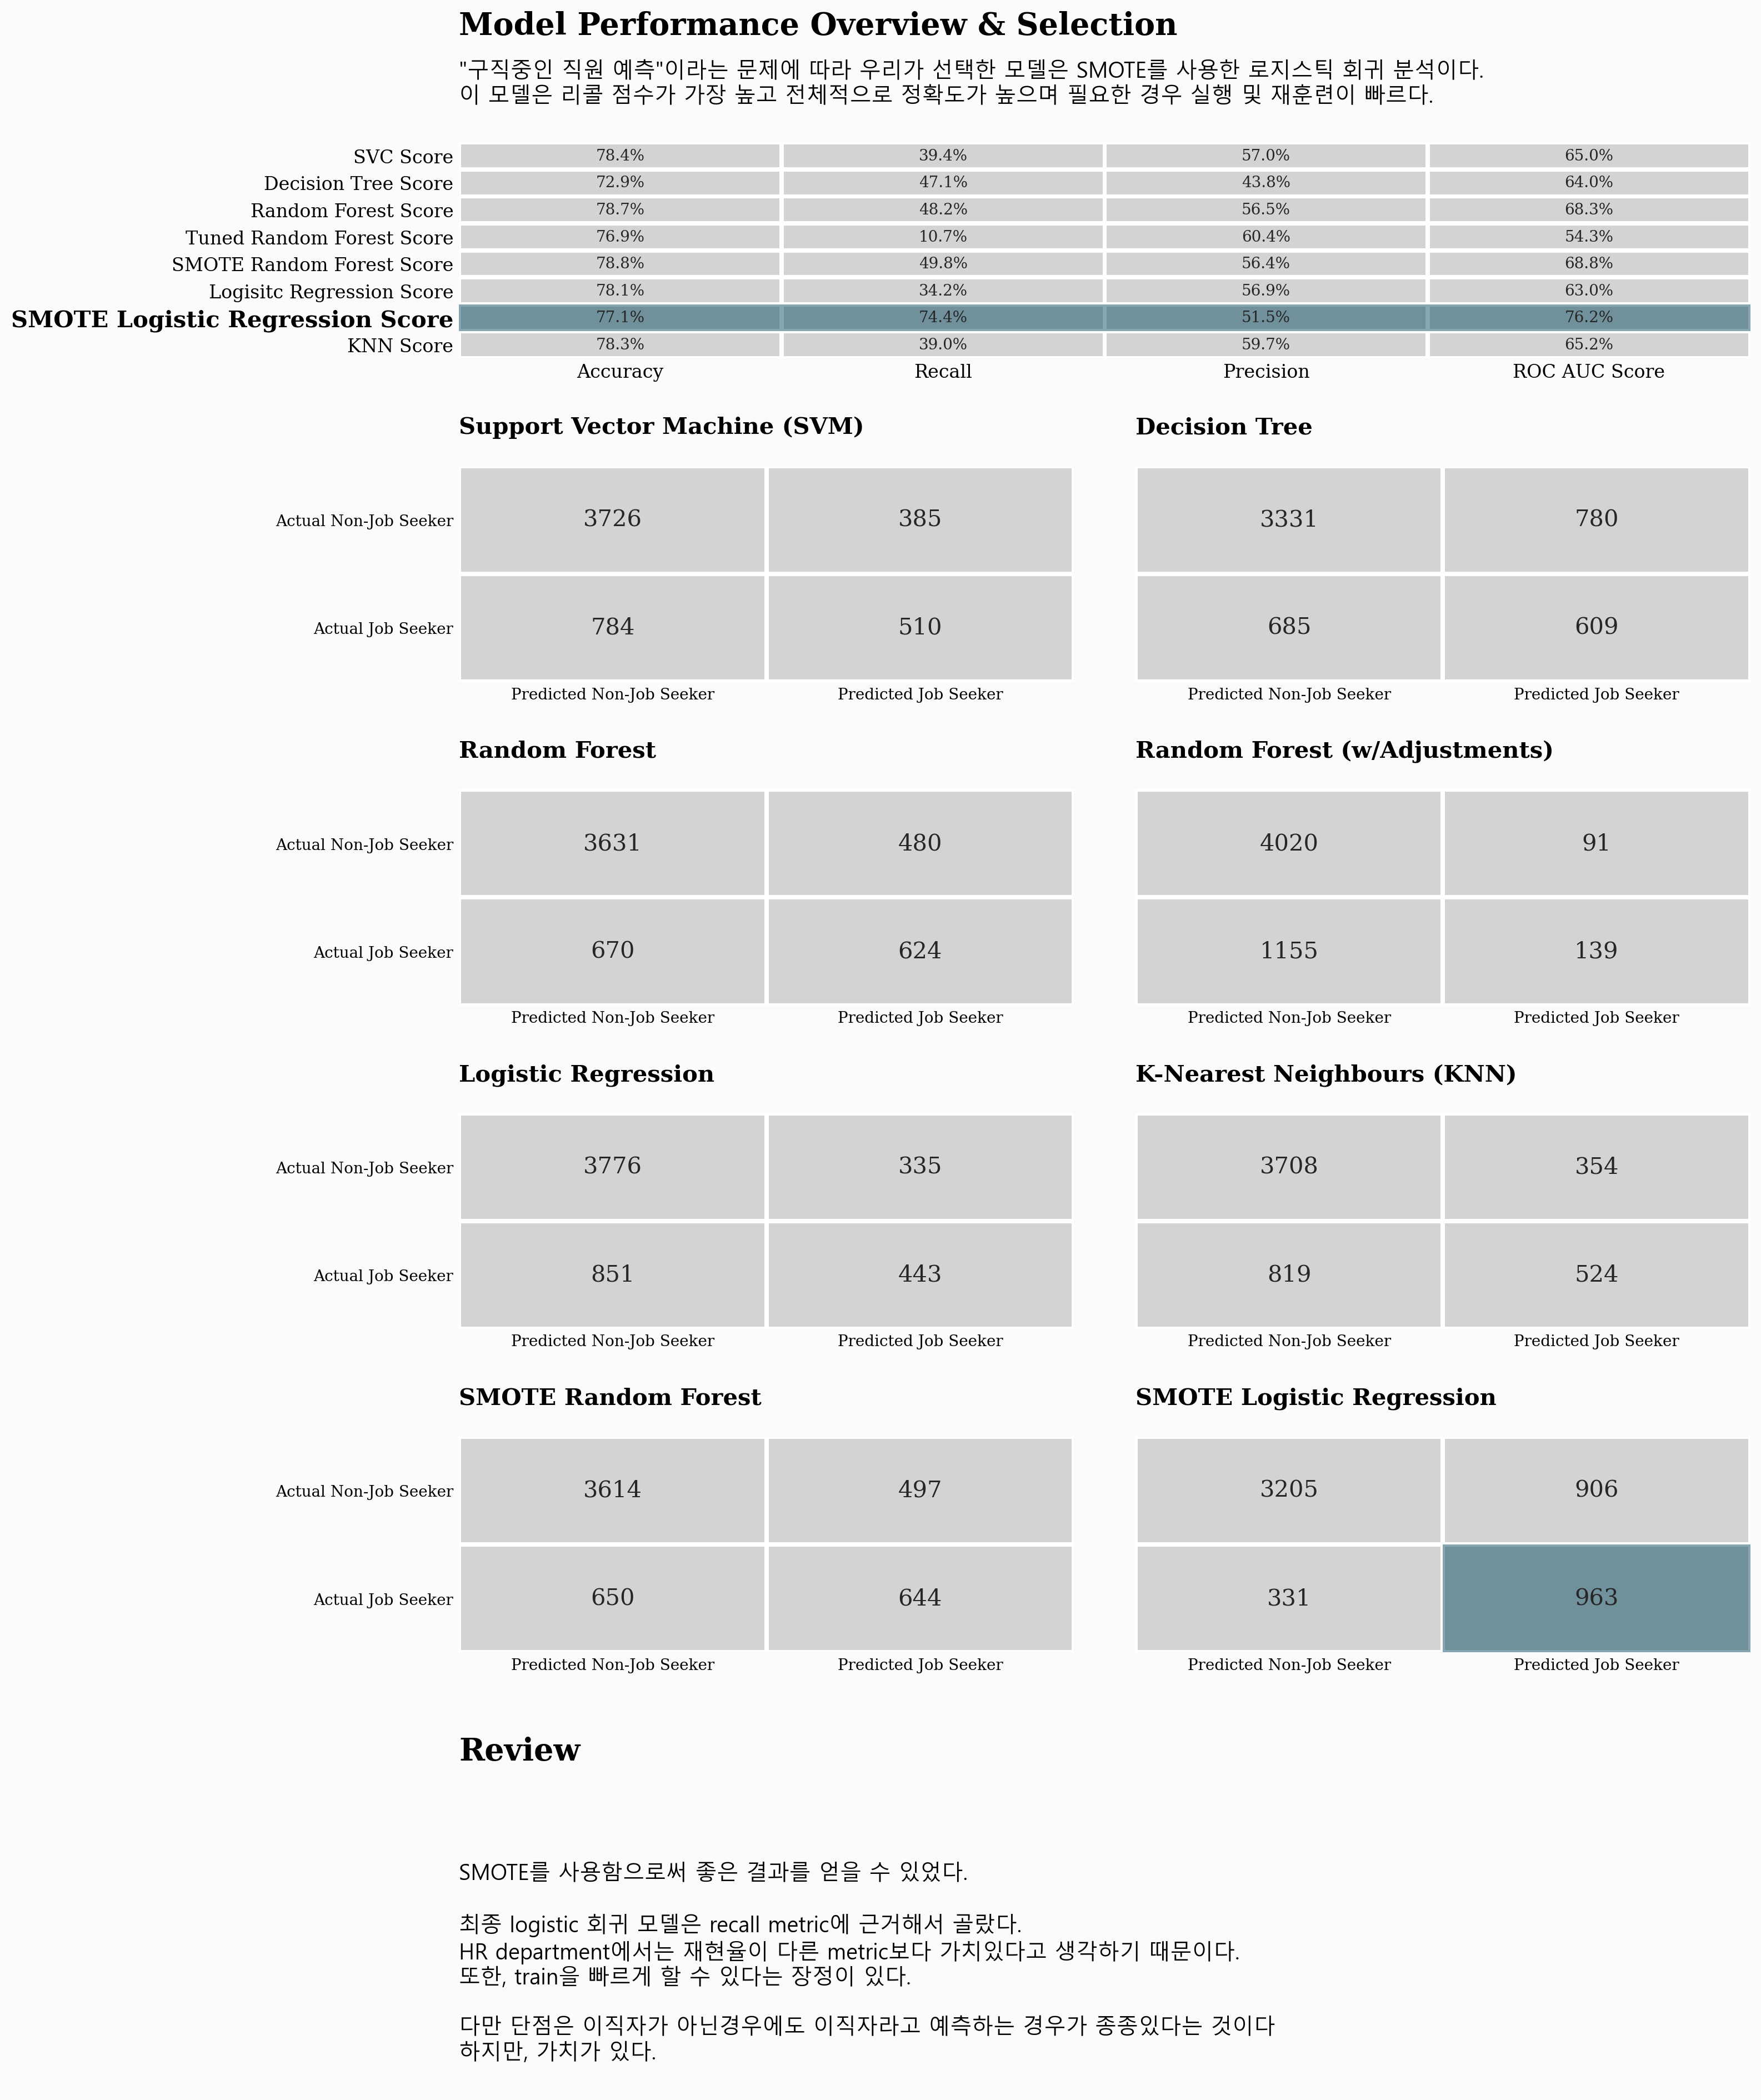

In [47]:
# Plotting our results

colors = ["lightgray","lightgray"]
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)


fig = plt.figure(figsize=(15,18)) # create figure
gs = fig.add_gridspec(5, 2)
gs.update(wspace=0.1, hspace=0.5)
ax0 = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[1, 1])
ax3 = fig.add_subplot(gs[2, 0])
ax4 = fig.add_subplot(gs[2, 1])
ax5 = fig.add_subplot(gs[3, 0])
ax6 = fig.add_subplot(gs[3,1])
ax7 = fig.add_subplot(gs[4,0])
ax8 = fig.add_subplot(gs[4,1])

# Overall
df_models = round(pd.concat([svc_df,dtree_df,rfc_df,trfc_df,smote_rf_df,log_df,smote_logreg_df,knn_df], axis=1),3)
sns.heatmap(df_models.T, cmap=colormap,annot=True,fmt=".1%", linewidths=2.5,cbar=False,ax=ax0)


ax0.set_yticklabels(ax0.get_yticklabels(), fontfamily='serif', rotation = 0, fontsize=12)
ax0.set_xticklabels(ax0.get_xticklabels(), fontfamily='serif', rotation=0, fontsize=12)

ax0.text(0,-4,'Model Performance Overview & Selection',fontfamily='serif',fontsize=20,fontweight='bold')
ax0.text(0,-0.55,
         '''
"구직중인 직원 예측"이라는 문제에 따라 우리가 선택한 모델은 SMOTE를 사용한 로지스틱 회귀 분석이다.
이 모델은 리콜 점수가 가장 높고 전체적으로 정확도가 높으며 필요한 경우 실행 및 재훈련이 빠르다.
'''
         ,fontproperties=fontprop,fontsize=14)



for lab, annot in zip(ax0.get_yticklabels(), ax0.texts):
    text =  lab.get_text()
    if text == 'SMOTE Logistic Regression Score': 
        # set the properties of the ticklabel
        lab.set_weight('bold')
        lab.set_size(15)
        lab.set_color('black')
        



from matplotlib.patches import Rectangle

rect = ax0.add_patch(Rectangle((0, 6), 5, 1, fill=True,color='#0e4f66', edgecolor='white', lw=0,alpha=0.5))



# svc
sns.heatmap(cm_svc, linewidths=2.5,yticklabels=['Actual Non-Job Seeker','Actual Job Seeker'],xticklabels=['Predicted Non-Job Seeker','Predicted Job Seeker'], cmap=colormap, cbar=None,annot=True,fmt='d',ax=ax1,annot_kws={"fontsize":15})

# dtree
sns.heatmap(cm_dtree, linewidths=2.5,yticklabels=False,xticklabels=['Predicted Non-Job Seeker','Predicted Job Seeker'], cmap=colormap, cbar=None,annot=True,fmt='d',ax=ax2,annot_kws={"fontsize":15})

# rf
sns.heatmap(cm_rfc, linewidths=2.5,yticklabels=['Actual Non-Job Seeker','Actual Job Seeker'],xticklabels=['Predicted Non-Job Seeker','Predicted Job Seeker'], cmap=colormap, cbar=None,annot=True,fmt='d',ax=ax3,annot_kws={"fontsize":15})

# tuned rf
sns.heatmap(cm_trfc, linewidths=2.5,yticklabels=False,xticklabels=['Predicted Non-Job Seeker','Predicted Job Seeker'], cmap=colormap, cbar=None,annot=True,fmt='d',ax=ax4,annot_kws={"fontsize":15})

# log
sns.heatmap(cm_log, linewidths=2.5,yticklabels=['Actual Non-Job Seeker','Actual Job Seeker'],xticklabels=['Predicted Non-Job Seeker','Predicted Job Seeker'], cmap=colormap, cbar=None,annot=True,fmt='d',ax=ax5,annot_kws={"fontsize":15})

# knn
sns.heatmap(cm_knn, linewidths=2.5,yticklabels=False,xticklabels=['Predicted Non-Job Seeker','Predicted Job Seeker'], cmap=colormap, cbar=None,annot=True,fmt='d',ax=ax6,annot_kws={"fontsize":15})

# smote rf
sns.heatmap(smote_cm_rf, linewidths=2.5,yticklabels=['Actual Non-Job Seeker','Actual Job Seeker'],xticklabels=['Predicted Non-Job Seeker','Predicted Job Seeker'], cmap=colormap, cbar=None,annot=True,fmt='d',ax=ax7,annot_kws={"fontsize":15})

# smote log reg
sns.heatmap(smote_cm_log, linewidths=2.5,yticklabels=False,xticklabels=['Predicted Non-Job Seeker','Predicted Job Seeker'], cmap=colormap, cbar=None,annot=True,fmt='d',ax=ax8,annot_kws={"fontsize":15})



background_color = "#fbfbfb"
fig.patch.set_facecolor(background_color) # figure background color
ax0.set_facecolor(background_color) # axes background color
ax1.set_facecolor(background_color)
ax2.set_facecolor(background_color)
ax3.set_facecolor(background_color)
ax4.set_facecolor(background_color)
ax5.set_facecolor(background_color)
ax6.set_facecolor(background_color)
ax7.set_facecolor(background_color)
ax8.set_facecolor(background_color)

ax0.set_xlabel("")
ax0.set_ylabel("")

for s in ["top","right","left"]:
    ax0.spines[s].set_visible(False)
    ax1.spines[s].set_visible(False)
    ax2.spines[s].set_visible(False)
    ax3.spines[s].set_visible(False)
    ax4.spines[s].set_visible(False)
    ax5.spines[s].set_visible(False)
    ax6.spines[s].set_visible(False)
    ax7.spines[s].set_visible(False)
    ax8.spines[s].set_visible(False)
    
    # Change background color
background_color = "#fbfbfb"
fig.patch.set_facecolor(background_color) # figure background color
ax0.set_facecolor(background_color) # axes background color



ax1.text(0, -0.3, 'Support Vector Machine (SVM)',fontsize=15, fontweight='bold', fontfamily='serif')
ax2.text(0, -0.3, 'Decision Tree', fontsize=15, fontweight='bold', fontfamily='serif')
ax3.text(0, -0.3, 'Random Forest',fontsize=15, fontweight='bold', fontfamily='serif')
ax4.text(0, -0.3, 'Random Forest (w/Adjustments)', fontsize=15, fontweight='bold', fontfamily='serif')
ax5.text(0, -0.3, 'Logistic Regression',fontsize=15, fontweight='bold', fontfamily='serif')
ax6.text(0, -0.3, 'K-Nearest Neighbours (KNN)', fontsize=15, fontweight='bold', fontfamily='serif')
ax7.text(0, -0.3, 'SMOTE Random Forest',fontsize=15, fontweight='bold', fontfamily='serif')
ax8.text(0, -0.3, 'SMOTE Logistic Regression', fontsize=15, fontweight='bold', fontfamily='serif')


ax7.text(0, 3, 'Review',fontsize=20, fontweight='bold', fontfamily='serif')
ax7.text(0, 6, 
'''
SMOTE를 사용함으로써 좋은 결과를 얻을 수 있었다.

최종 logistic 회귀 모델은 recall metric에 근거해서 골랐다.
HR department에서는 재현율이 다른 metric보다 가치있다고 생각하기 때문이다.
또한, train을 빠르게 할 수 있다는 장정이 있다.

다만 단점은 이직자가 아닌경우에도 이직자라고 예측하는 경우가 종종있다는 것이다
하지만, 가치가 있다.
''',fontsize=14, fontproperties=fontprop)


from matplotlib.patches import Rectangle


ax8.add_patch(Rectangle((1, 1), 1, 1, fill=True,color='#0e4f66', edgecolor='white', lw=0,alpha=0.5))

colors = ['gray','#0e4f66','#002d1d']
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

ax0.tick_params(axis=u'both', which=u'both',length=0)
ax1.tick_params(axis=u'both', which=u'both',length=0)
ax2.tick_params(axis=u'both', which=u'both',length=0)
ax3.tick_params(axis=u'both', which=u'both',length=0)
ax4.tick_params(axis=u'both', which=u'both',length=0)
ax5.tick_params(axis=u'both', which=u'both',length=0)
ax6.tick_params(axis=u'both', which=u'both',length=0)
ax7.tick_params(axis=u'both', which=u'both',length=0)
ax8.tick_params(axis=u'both', which=u'both',length=0)

plt.show()

# Conclusion

**So there we have it**

우리는 사람들로 하여금 읽도록 data를 흥미로운 방법들로 탐색하고 시각화했다

우리는 data를 완벽하게 보기 위해서 결측값들을 다루고 feature enginnering을 했다.

또한, UMAP으로 data를 변형시켜서 봤다.

마지막으로, machine learning 알고리즘으로 그들이 이직자일지 아닐지 예측하는 시도를 했다.
우리가 본 것이다.:
- SVM
- SVM with UMAP dimensionality reduction
- Decision Trees
- Random Forests
- Logisitic Regression
- KNN

우리는 불균형한 데이터를 다루는 것을 했고, 이것은 모델을 향상 시켰다.

SMOTE방법을 사용했고 다시 logistics 회귀와 rf 모델로 재훈련 했다. logistic 회귀가 괜찮았다.

fine-tune까지는 하지 않았고, 최종 score는 더 올라갈 수 있을 것이다. 

올릴 방법은 다음과 같다.: 

- Hyperparameter tuning
- Threshold manipulation (임계값 조절)

또한 찾은 것들을 비즈니스 이해 관계자한테 결과를 설명했다.

# More of Josh work

**Exploratory Data Analysis - Student Performance**

https://www.kaggle.com/joshuaswords/data-visualisation-student-results

**Netflix Data Visualisation**

https://www.kaggle.com/joshuaswords/netflix-data-visualization

**Clustering and how you can visualise and share results in industry**

https://www.kaggle.com/joshuaswords/data-visualization-clustering-mall-data


**Stroke Prediction with SMOTE and LIME explainer**

https://www.kaggle.com/joshuaswords/predicting-a-stroke-95-acc-with-lime-explainer